In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
best_combination


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.5289 - accuracy: 0.6584 - precision: 0.9514 - recall: 0.6324 - f1: 0.7520 - specificity: 0.8221 - negative_predictive_value: 0.2959 - matthews_correlation_coefficient: 0.3307 - val_loss: 0.4951 - val_accuracy: 0.6713 - val_precision: 0.9381 - val_recall: 0.6171 - val_f1: 0.7406 - val_specificity: 0.8470 - val_negative_predictive_value: 0.3220 - val_matthews_correlation_coefficient: 0.3448

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34478, saving model to ../models/autoencoders_requirements/blurred_2020_04_05-12_32_09.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4901 - accuracy: 0.6664 - precision: 0.9643 - recall: 0.6341 - f1: 0.7568 - specificity: 0.8629 - negative_predictive_value: 0.3126 - matthews_correlation_coefficient: 0.3656 - val_loss: 0.5733 - val_accuracy: 0.5880 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient improved from 0.39489 to 0.39607, saving model to ../models/autoencoders_requirements/blurred_2020_04_05-12_32_09.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4473 - accuracy: 0.7102 - precision: 0.9656 - recall: 0.6861 - f1: 0.7971 - specificity: 0.8483 - negative_predictive_value: 0.3294 - matthews_correlation_coefficient: 0.3879 - val_loss: 0.4804 - val_accuracy: 0.7077 - val_precision: 0.9468 - val_recall: 0.6550 - val_f1: 0.7697 - val_specificity: 0.8762 - val_negative_predictive_value: 0.3562 - val_matthews_correlation_coefficient: 0.3979

Epoch 00015: val_matthews_correlation_coefficient improved from 0.39607 to 0.39790, saving model to ../models/autoencoders_requirements/blurred_2020_04_05-12_32_09.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4483 - accuracy: 0.7182 - precision: 0.9651 - recall: 0.6946 - f1: 0.8031 - specificity: 0.8654 - negative_predi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4305 - accuracy: 0.7479 - precision: 0.9676 - recall: 0.7294 - f1: 0.8273 - specificity: 0.8631 - negative_predictive_value: 0.3757 - matthews_correlation_coefficient: 0.4441 - val_loss: 0.4601 - val_accuracy: 0.7459 - val_precision: 0.9341 - val_recall: 0.7106 - val_f1: 0.8033 - val_specificity: 0.8022 - val_negative_predictive_value: 0.3801 - val_matthews_correlation_coefficient: 0.3984

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41649
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4260 - accuracy: 0.7362 - precision: 0.9685 - recall: 0.7136 - f1: 0.8174 - specificity: 0.8655 - negative_predictive_value: 0.3632 - matthews_correlation_coefficient: 0.4328 - val_loss: 0.4059 - val_accuracy: 0.7736 - val_precision: 0.9332 - val_recall: 0.7460 - val_f1: 0.8258 - val_specificity: 0.7752 - val_negative_predictive_value: 0.3861 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient improved from 0.43140 to 0.44075, saving model to ../models/autoencoders_requirements/blurred_2020_04_05-12_32_09.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4099 - accuracy: 0.7594 - precision: 0.9700 - recall: 0.7391 - f1: 0.8350 - specificity: 0.8688 - negative_predictive_value: 0.3873 - matthews_correlation_coefficient: 0.4594 - val_loss: 0.3585 - val_accuracy: 0.8092 - val_precision: 0.9110 - val_recall: 0.8096 - val_f1: 0.8543 - val_specificity: 0.6635 - val_negative_predictive_value: 0.4294 - val_matthews_correlation_coefficient: 0.4232

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44075
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4106 - accuracy: 0.7495 - precision: 0.9714 - recall: 0.7273 - f1: 0.8279 - specificity: 0.8777 - negative_predictive_value: 0.3769 - matthews_correlation_coefficient: 0.4531 - val_loss: 0.3626 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3934 - accuracy: 0.7690 - precision: 0.9725 - recall: 0.7502 - f1: 0.8435 - specificity: 0.8732 - negative_predictive_value: 0.3958 - matthews_correlation_coefficient: 0.4731 - val_loss: 0.3858 - val_accuracy: 0.7927 - val_precision: 0.9265 - val_recall: 0.7738 - val_f1: 0.8401 - val_specificity: 0.7599 - val_negative_predictive_value: 0.4292 - val_matthews_correlation_coefficient: 0.4324

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.46734
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4038 - accuracy: 0.7625 - precision: 0.9745 - recall: 0.7410 - f1: 0.8383 - specificity: 0.8837 - negative_predictive_value: 0.3854 - matthews_correlation_coefficient: 0.4672 - val_loss: 0.3541 - val_accuracy: 0.8196 - val_precision: 0.9266 - val_recall: 0.8067 - val_f1: 0.8605 - val_specificity: 0.7230 - val_negative_predictive_value: 0.4421 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3919 - accuracy: 0.7649 - precision: 0.9719 - recall: 0.7461 - f1: 0.8403 - specificity: 0.8771 - negative_predictive_value: 0.3898 - matthews_correlation_coefficient: 0.4669 - val_loss: 0.3715 - val_accuracy: 0.8101 - val_precision: 0.9249 - val_recall: 0.7966 - val_f1: 0.8538 - val_specificity: 0.7298 - val_negative_predictive_value: 0.4408 - val_matthews_correlation_coefficient: 0.4362

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46734
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3756 - accuracy: 0.7872 - precision: 0.9700 - recall: 0.7700 - f1: 0.8550 - specificity: 0.8915 - negative_predictive_value: 0.4143 - matthews_correlation_coefficient: 0.5004 - val_loss: 0.4506 - val_accuracy: 0.7476 - val_precision: 0.9440 - val_recall: 0.7050 - val_f1: 0.8040 - val_specificity: 0.8479 - val_negative_predictive_value: 0.3822 - val_matthews_correlation_coefficie

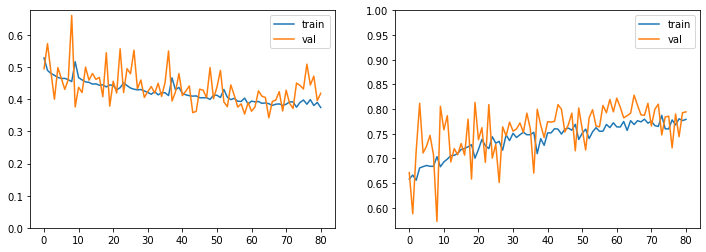

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6701 - accuracy: 0.5889 - precision: 0.7551 - recall: 0.5836 - f1: 0.6404 - specificity: 0.5956 - negative_predictive_value: 0.4082 - matthews_correlation_coefficient: 0.1763 - val_loss: 0.6917 - val_accuracy: 0.5594 - val_precision: 0.7787 - val_recall: 0.4499 - val_f1: 0.5650 - val_specificity: 0.7695 - val_negative_predictive_value: 0.4104 - val_matthews_correlation_coefficient: 0.2025

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20251, saving model to ../models/autoencoders_requirements/looking_away_2020_04_05-12_44_24.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6656 - accuracy: 0.6117 - precision: 0.7730 - recall: 0.6226 - f1: 0.6795 - specificity: 0.6006 - negative_predictive_value: 0.4282 - matthews_correlation_coefficient: 0.2112 - val_loss: 0.6728 - val_accuracy: 0.5880 - val_precisio

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6211 - accuracy: 0.6577 - precision: 0.8188 - recall: 0.6479 - f1: 0.7125 - specificity: 0.6815 - negative_predictive_value: 0.4766 - matthews_correlation_coefficient: 0.3123 - val_loss: 0.5906 - val_accuracy: 0.6860 - val_precision: 0.8124 - val_recall: 0.6571 - val_f1: 0.7212 - val_specificity: 0.7211 - val_negative_predictive_value: 0.5156 - val_matthews_correlation_coefficient: 0.3512

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35863
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6124 - accuracy: 0.6633 - precision: 0.8183 - recall: 0.6637 - f1: 0.7246 - specificity: 0.6690 - negative_predictive_value: 0.4779 - matthews_correlation_coefficient: 0.3129 - val_loss: 0.5731 - val_accuracy: 0.7112 - val_precision: 0.7883 - val_recall: 0.7359 - val_f1: 0.7566 - val_specificity: 0.6237 - val_negative_predictive_value: 0.5485 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38915
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5866 - accuracy: 0.6907 - precision: 0.8360 - recall: 0.6907 - f1: 0.7474 - specificity: 0.6965 - negative_predictive_value: 0.5181 - matthews_correlation_coefficient: 0.3692 - val_loss: 0.6696 - val_accuracy: 0.6505 - val_precision: 0.8230 - val_recall: 0.5796 - val_f1: 0.6750 - val_specificity: 0.7772 - val_negative_predictive_value: 0.4803 - val_matthews_correlation_coefficient: 0.3277

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38915
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5839 - accuracy: 0.6850 - precision: 0.8333 - recall: 0.6831 - f1: 0.7427 - specificity: 0.6924 - negative_predictive_value: 0.4992 - matthews_correlation_coefficient: 0.3537 - val_loss: 0.5947 - val_accuracy: 0.6834 - val_precision: 0.8166 - val_recall: 0.6454 - val_f1: 0.7167 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5687 - accuracy: 0.7033 - precision: 0.8314 - recall: 0.7196 - f1: 0.7646 - specificity: 0.6779 - negative_predictive_value: 0.5302 - matthews_correlation_coefficient: 0.3779 - val_loss: 0.6856 - val_accuracy: 0.5958 - val_precision: 0.8711 - val_recall: 0.4529 - val_f1: 0.5903 - val_specificity: 0.8945 - val_negative_predictive_value: 0.4469 - val_matthews_correlation_coefficient: 0.3305

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.40214
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5658 - accuracy: 0.7002 - precision: 0.8385 - recall: 0.6900 - f1: 0.7481 - specificity: 0.7098 - negative_predictive_value: 0.5217 - matthews_correlation_coefficient: 0.3779 - val_loss: 0.6387 - val_accuracy: 0.6418 - val_precision: 0.8401 - val_recall: 0.5524 - val_f1: 0.6615 - val_specificity: 0.8149 - val_negative_predictive_value: 0.4740 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient improved from 0.40375 to 0.40408, saving model to ../models/autoencoders_requirements/looking_away_2020_04_05-12_44_24.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5538 - accuracy: 0.7165 - precision: 0.8387 - recall: 0.7195 - f1: 0.7658 - specificity: 0.7075 - negative_predictive_value: 0.5429 - matthews_correlation_coefficient: 0.4019 - val_loss: 0.5841 - val_accuracy: 0.6756 - val_precision: 0.8569 - val_recall: 0.5948 - val_f1: 0.6964 - val_specificity: 0.8265 - val_negative_predictive_value: 0.5032 - val_matthews_correlation_coefficient: 0.3878

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40408
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5536 - accuracy: 0.7095 - precision: 0.8430 - recall: 0.7140 - f1: 0.7647 - specificity: 0.7054 - negative_predictive_value: 0.5291 - matthews_correlation_coefficient: 0.3955 - val_loss: 0.7080 -


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40408
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5484 - accuracy: 0.7126 - precision: 0.8572 - recall: 0.7048 - f1: 0.7646 - specificity: 0.7267 - negative_predictive_value: 0.5361 - matthews_correlation_coefficient: 0.4124 - val_loss: 0.5759 - val_accuracy: 0.6912 - val_precision: 0.8340 - val_recall: 0.6374 - val_f1: 0.7188 - val_specificity: 0.7757 - val_negative_predictive_value: 0.5172 - val_matthews_correlation_coefficient: 0.3794

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40408
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5452 - accuracy: 0.7206 - precision: 0.8509 - recall: 0.7234 - f1: 0.7748 - specificity: 0.7133 - negative_predictive_value: 0.5427 - matthews_correlation_coefficient: 0.4151 - val_loss: 0.7101 - val_accuracy: 0.5906 - val_precision: 0.8600 - val_recall: 0.4541 - val_f1: 0.5882 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.41289
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5377 - accuracy: 0.7269 - precision: 0.8542 - recall: 0.7294 - f1: 0.7785 - specificity: 0.7182 - negative_predictive_value: 0.5568 - matthews_correlation_coefficient: 0.4287 - val_loss: 0.6217 - val_accuracy: 0.6687 - val_precision: 0.8325 - val_recall: 0.5989 - val_f1: 0.6931 - val_specificity: 0.7865 - val_negative_predictive_value: 0.4944 - val_matthews_correlation_coefficient: 0.3536

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.41289
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5366 - accuracy: 0.7282 - precision: 0.8571 - recall: 0.7280 - f1: 0.7798 - specificity: 0.7249 - negative_predictive_value: 0.5609 - matthews_correlation_coefficient: 0.4354 - val_loss: 0.6258 - val_accuracy: 0.6340 - val_precision: 0.8661 - val_recall: 0.5189 - val_f1: 0.6434 - val_spe

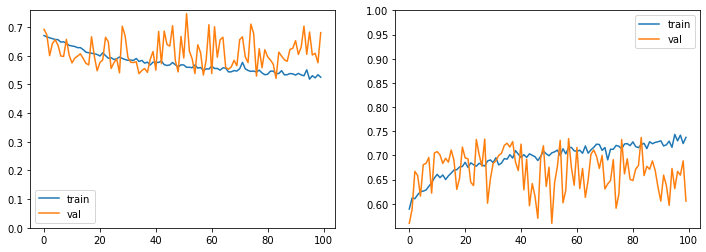

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.7725 - accuracy: 0.4410 - precision: 0.8415 - recall: 0.4449 - f1: 0.5170 - specificity: 0.0483 - negative_predictive_value: 0.0027 - matthews_correlation_coefficient: -0.0061 - val_loss: 0.2692 - val_accuracy: 0.9965 - val_precision: 0.9966 - val_recall: 1.0000 - val_f1: 0.9983 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00000, saving model to ../models/autoencoders_requirements/ink_marked_creased_2020_04_05-12_59_29.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.8610 - accuracy: 0.3805 - precision: 0.6933 - recall: 0.3785 - f1: 0.4348 - specificity: 0.0483 - negative_predictive_value: 0.0021 - matthews_correlation_coefficient: -0.0018 - val_loss: 0.7803 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6962 - accuracy: 0.5983 - precision: 0.9894 - recall: 0.5954 - f1: 0.7223 - specificity: 0.0379 - negative_predictive_value: 0.0025 - matthews_correlation_coefficient: -0.0011 - val_loss: 0.8263 - val_accuracy: 0.2819 - val_precision: 0.9970 - val_recall: 0.2992 - val_f1: 0.4462 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0037 - val_matthews_correlation_coefficient: 0.0021

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.01015
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6865 - accuracy: 0.5369 - precision: 0.9910 - recall: 0.5331 - f1: 0.6795 - specificity: 0.0759 - negative_predictive_value: 0.0056 - matthews_correlation_coefficient: 0.0090 - val_loss: 0.7624 - val_accuracy: 0.3495 - val_precision: 0.9958 - val_recall: 0.3662 - val_f1: 0.5239 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0028 - val_matthews_correlation_coeffici


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.01015
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6731 - accuracy: 0.4312 - precision: 0.9976 - recall: 0.4308 - f1: 0.5977 - specificity: 0.0759 - negative_predictive_value: 0.0049 - matthews_correlation_coefficient: 0.0064 - val_loss: 0.7210 - val_accuracy: 0.3877 - val_precision: 0.9944 - val_recall: 0.4044 - val_f1: 0.5639 - val_specificity: 0.0270 - val_negative_predictive_value: 0.0014 - val_matthews_correlation_coefficient: -0.0117

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.01015
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6545 - accuracy: 0.3848 - precision: 0.9989 - recall: 0.3837 - f1: 0.5494 - specificity: 0.0966 - negative_predictive_value: 0.0052 - matthews_correlation_coefficient: 0.0108 - val_loss: 0.5990 - val_accuracy: 0.5438 - val_precision: 0.9959 - val_recall: 0.5570 - val_f1: 0.7088 - val_sp

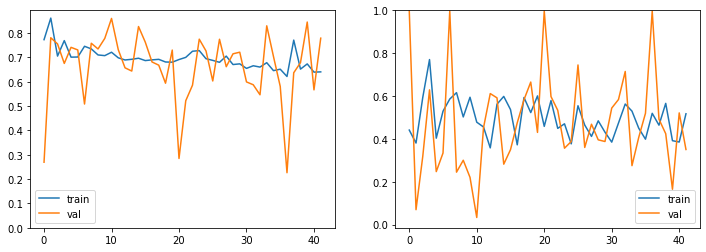

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6487 - accuracy: 0.6137 - precision: 0.5661 - recall: 0.6587 - f1: 0.5607 - specificity: 0.5812 - negative_predictive_value: 0.7213 - matthews_correlation_coefficient: 0.2600 - val_loss: 0.6574 - val_accuracy: 0.5646 - val_precision: 0.4797 - val_recall: 0.0692 - val_f1: 0.1174 - val_specificity: 0.9250 - val_negative_predictive_value: 0.5502 - val_matthews_correlation_coefficient: 0.0473

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.04733, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_04_05-13_05_45.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6003 - accuracy: 0.6766 - precision: 0.5995 - recall: 0.7631 - f1: 0.6546 - specificity: 0.6072 - negative_predictive_value: 0.7862 - matthews_correlation_coefficient: 0.3855 - val_loss: 0.5786 - val_accuracy: 0.6930 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5091 - accuracy: 0.7273 - precision: 0.6621 - recall: 0.8166 - f1: 0.7202 - specificity: 0.6680 - negative_predictive_value: 0.8255 - matthews_correlation_coefficient: 0.4855 - val_loss: 0.5566 - val_accuracy: 0.6947 - val_precision: 0.6259 - val_recall: 0.6688 - val_f1: 0.6393 - val_specificity: 0.6816 - val_negative_predictive_value: 0.7181 - val_matthews_correlation_coefficient: 0.3740

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.45725
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5005 - accuracy: 0.7388 - precision: 0.6652 - recall: 0.8065 - f1: 0.7187 - specificity: 0.6825 - negative_predictive_value: 0.8210 - matthews_correlation_coefficient: 0.4940 - val_loss: 0.5340 - val_accuracy: 0.7173 - val_precision: 0.6282 - val_recall: 0.7747 - val_f1: 0.6873 - val_specificity: 0.6381 - val_negative_predictive_value: 0.7816 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4815 - accuracy: 0.7538 - precision: 0.6986 - recall: 0.8063 - f1: 0.7359 - specificity: 0.7228 - negative_predictive_value: 0.8262 - matthews_correlation_coefficient: 0.5263 - val_loss: 0.5202 - val_accuracy: 0.7199 - val_precision: 0.6614 - val_recall: 0.6682 - val_f1: 0.6571 - val_specificity: 0.7237 - val_negative_predictive_value: 0.7320 - val_matthews_correlation_coefficient: 0.4194

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.45725
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4748 - accuracy: 0.7638 - precision: 0.7024 - recall: 0.8001 - f1: 0.7384 - specificity: 0.7326 - negative_predictive_value: 0.8305 - matthews_correlation_coefficient: 0.5342 - val_loss: 0.5218 - val_accuracy: 0.7190 - val_precision: 0.7055 - val_recall: 0.5425 - val_f1: 0.6069 - val_specificity: 0.8181 - val_negative_predictive_value: 0.6910 - val_matthews_correlation_coefficie


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.48913
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4563 - accuracy: 0.7761 - precision: 0.7226 - recall: 0.8153 - f1: 0.7567 - specificity: 0.7422 - negative_predictive_value: 0.8338 - matthews_correlation_coefficient: 0.5583 - val_loss: 0.4990 - val_accuracy: 0.7467 - val_precision: 0.7213 - val_recall: 0.6296 - val_f1: 0.6642 - val_specificity: 0.8017 - val_negative_predictive_value: 0.7299 - val_matthews_correlation_coefficient: 0.4675

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.48913
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4649 - accuracy: 0.7714 - precision: 0.7141 - recall: 0.7991 - f1: 0.7431 - specificity: 0.7466 - negative_predictive_value: 0.8329 - matthews_correlation_coefficient: 0.5475 - val_loss: 0.5218 - val_accuracy: 0.7363 - val_precision: 0.6839 - val_recall: 0.6677 - val_f1: 0.6697 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.48913
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4516 - accuracy: 0.7751 - precision: 0.7364 - recall: 0.7846 - f1: 0.7458 - specificity: 0.7654 - negative_predictive_value: 0.8170 - matthews_correlation_coefficient: 0.5527 - val_loss: 0.5177 - val_accuracy: 0.7459 - val_precision: 0.6769 - val_recall: 0.7195 - val_f1: 0.6912 - val_specificity: 0.7295 - val_negative_predictive_value: 0.7690 - val_matthews_correlation_coefficient: 0.4743

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.48913
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4480 - accuracy: 0.7796 - precision: 0.7228 - recall: 0.8045 - f1: 0.7528 - specificity: 0.7513 - negative_predictive_value: 0.8319 - matthews_correlation_coefficient: 0.5618 - val_loss: 0.5093 - val_accuracy: 0.7363 - val_precision: 0.6966 - val_recall: 0.6347 - val_f1: 0.6568 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.50750
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4384 - accuracy: 0.7887 - precision: 0.7480 - recall: 0.8076 - f1: 0.7680 - specificity: 0.7789 - negative_predictive_value: 0.8381 - matthews_correlation_coefficient: 0.5858 - val_loss: 0.4992 - val_accuracy: 0.7337 - val_precision: 0.6884 - val_recall: 0.6500 - val_f1: 0.6618 - val_specificity: 0.7652 - val_negative_predictive_value: 0.7314 - val_matthews_correlation_coefficient: 0.4442

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.50750
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4369 - accuracy: 0.7900 - precision: 0.7351 - recall: 0.8051 - f1: 0.7600 - specificity: 0.7708 - negative_predictive_value: 0.8345 - matthews_correlation_coefficient: 0.5723 - val_loss: 0.4988 - val_accuracy: 0.7546 - val_precision: 0.7043 - val_recall: 0.6882 - val_f1: 0.6906 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4250 - accuracy: 0.8017 - precision: 0.7510 - recall: 0.8062 - f1: 0.7695 - specificity: 0.7916 - negative_predictive_value: 0.8482 - matthews_correlation_coefficient: 0.5998 - val_loss: 0.5091 - val_accuracy: 0.7502 - val_precision: 0.7180 - val_recall: 0.6389 - val_f1: 0.6691 - val_specificity: 0.8020 - val_negative_predictive_value: 0.7367 - val_matthews_correlation_coefficient: 0.4745

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.51489
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4145 - accuracy: 0.8052 - precision: 0.7620 - recall: 0.8134 - f1: 0.7789 - specificity: 0.7926 - negative_predictive_value: 0.8425 - matthews_correlation_coefficient: 0.6066 - val_loss: 0.4963 - val_accuracy: 0.7658 - val_precision: 0.7262 - val_recall: 0.6852 - val_f1: 0.6981 - val_specificity: 0.7958 - val_negative_predictive_value: 0.7590 - val_matthews_correlation_coefficie

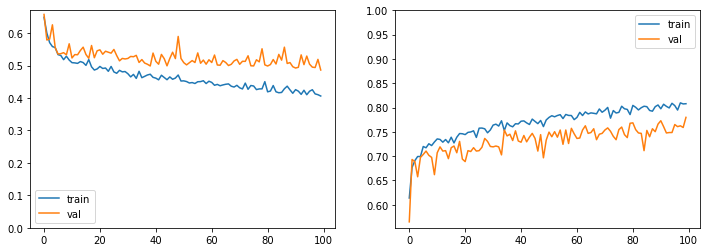

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5807 - accuracy: 0.7039 - precision: 0.9688 - recall: 0.7037 - f1: 0.7913 - specificity: 0.6708 - negative_predictive_value: 0.2323 - matthews_correlation_coefficient: 0.2751 - val_loss: 0.5796 - val_accuracy: 0.7069 - val_precision: 0.9606 - val_recall: 0.6714 - val_f1: 0.7865 - val_specificity: 0.8414 - val_negative_predictive_value: 0.2128 - val_matthews_correlation_coefficient: 0.2934

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29335, saving model to ../models/autoencoders_requirements/too_dark_light_2020_04_05-13_20_27.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4482 - accuracy: 0.8080 - precision: 0.9811 - recall: 0.8094 - f1: 0.8809 - specificity: 0.7824 - negative_predictive_value: 0.3003 - matthews_correlation_coefficient: 0.3978 - val_loss: 0.4712 - val_accuracy: 0.8049 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3511 - accuracy: 0.8672 - precision: 0.9837 - recall: 0.8722 - f1: 0.9230 - specificity: 0.7802 - negative_predictive_value: 0.3610 - matthews_correlation_coefficient: 0.4652 - val_loss: 0.3113 - val_accuracy: 0.8794 - val_precision: 0.9516 - val_recall: 0.8659 - val_f1: 0.9055 - val_specificity: 0.6979 - val_negative_predictive_value: 0.3555 - val_matthews_correlation_coefficient: 0.4047

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.45502
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3406 - accuracy: 0.8679 - precision: 0.9859 - recall: 0.8668 - f1: 0.9202 - specificity: 0.8091 - negative_predictive_value: 0.3767 - matthews_correlation_coefficient: 0.4837 - val_loss: 0.2858 - val_accuracy: 0.8925 - val_precision: 0.9534 - val_recall: 0.8782 - val_f1: 0.9134 - val_specificity: 0.7272 - val_negative_predictive_value: 0.4101 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.48850
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3244 - accuracy: 0.8683 - precision: 0.9852 - recall: 0.8711 - f1: 0.9229 - specificity: 0.7660 - negative_predictive_value: 0.3698 - matthews_correlation_coefficient: 0.4688 - val_loss: 0.4108 - val_accuracy: 0.8187 - val_precision: 0.9615 - val_recall: 0.7913 - val_f1: 0.8669 - val_specificity: 0.8286 - val_negative_predictive_value: 0.3066 - val_matthews_correlation_coefficient: 0.4001

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.48850
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3131 - accuracy: 0.8766 - precision: 0.9871 - recall: 0.8792 - f1: 0.9286 - specificity: 0.7886 - negative_predictive_value: 0.3824 - matthews_correlation_coefficient: 0.4875 - val_loss: 0.3355 - val_accuracy: 0.8708 - val_precision: 0.9615 - val_recall: 0.8467 - val_f1: 0.8997 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.48850
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2919 - accuracy: 0.8863 - precision: 0.9880 - recall: 0.8851 - f1: 0.9319 - specificity: 0.7941 - negative_predictive_value: 0.3995 - matthews_correlation_coefficient: 0.5048 - val_loss: 0.4452 - val_accuracy: 0.8075 - val_precision: 0.9635 - val_recall: 0.7772 - val_f1: 0.8589 - val_specificity: 0.8624 - val_negative_predictive_value: 0.2983 - val_matthews_correlation_coefficient: 0.3998

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.48850
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2950 - accuracy: 0.8811 - precision: 0.9879 - recall: 0.8802 - f1: 0.9292 - specificity: 0.8083 - negative_predictive_value: 0.3826 - matthews_correlation_coefficient: 0.4980 - val_loss: 0.4574 - val_accuracy: 0.8153 - val_precision: 0.9672 - val_recall: 0.7830 - val_f1: 0.8640 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2769 - accuracy: 0.8892 - precision: 0.9895 - recall: 0.8897 - f1: 0.9356 - specificity: 0.8301 - negative_predictive_value: 0.4091 - matthews_correlation_coefficient: 0.5245 - val_loss: 0.2462 - val_accuracy: 0.9055 - val_precision: 0.9620 - val_recall: 0.8836 - val_f1: 0.9204 - val_specificity: 0.8376 - val_negative_predictive_value: 0.4539 - val_matthews_correlation_coefficient: 0.5357

Epoch 00059: val_matthews_correlation_coefficient improved from 0.53187 to 0.53571, saving model to ../models/autoencoders_requirements/too_dark_light_2020_04_05-13_20_27.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2672 - accuracy: 0.8970 - precision: 0.9906 - recall: 0.8949 - f1: 0.9386 - specificity: 0.8661 - negative_predictive_value: 0.4452 - matthews_correlation_coefficient: 0.5646 - val_loss: 0.3356 - val_accuracy: 0.8699 - val_precision: 0.9634 - val_recall: 0.8442 - val_f1: 0.8988 - val_s


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.53571
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2501 - accuracy: 0.8952 - precision: 0.9881 - recall: 0.8950 - f1: 0.9378 - specificity: 0.7921 - negative_predictive_value: 0.4139 - matthews_correlation_coefficient: 0.5191 - val_loss: 0.3684 - val_accuracy: 0.8491 - val_precision: 0.9632 - val_recall: 0.8224 - val_f1: 0.8861 - val_specificity: 0.8398 - val_negative_predictive_value: 0.3516 - val_matthews_correlation_coefficient: 0.4451

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.53571
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2730 - accuracy: 0.8846 - precision: 0.9889 - recall: 0.8863 - f1: 0.9331 - specificity: 0.8242 - negative_predictive_value: 0.4168 - matthews_correlation_coefficient: 0.5279 - val_loss: 0.2997 - val_accuracy: 0.8794 - val_precision: 0.9624 - val_recall: 0.8547 - val_f1: 0.9046 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2381 - accuracy: 0.8998 - precision: 0.9913 - recall: 0.9001 - f1: 0.9424 - specificity: 0.8317 - negative_predictive_value: 0.4420 - matthews_correlation_coefficient: 0.5521 - val_loss: 0.3529 - val_accuracy: 0.8500 - val_precision: 0.9643 - val_recall: 0.8221 - val_f1: 0.8864 - val_specificity: 0.8488 - val_negative_predictive_value: 0.3442 - val_matthews_correlation_coefficient: 0.4450

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.54622
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2450 - accuracy: 0.8963 - precision: 0.9895 - recall: 0.8978 - f1: 0.9399 - specificity: 0.8557 - negative_predictive_value: 0.4449 - matthews_correlation_coefficient: 0.5577 - val_loss: 0.4120 - val_accuracy: 0.8300 - val_precision: 0.9648 - val_recall: 0.8001 - val_f1: 0.8737 - val_specificity: 0.8714 - val_negative_predictive_value: 0.3210 - val_matthews_correlation_coefficie

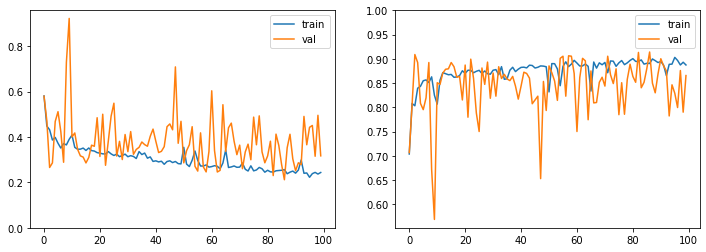

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5613 - accuracy: 0.6961 - precision: 0.9942 - recall: 0.6992 - f1: 0.8134 - specificity: 0.2241 - negative_predictive_value: 0.0296 - matthews_correlation_coefficient: 0.0533 - val_loss: 0.5021 - val_accuracy: 0.6340 - val_precision: 0.9938 - val_recall: 0.6436 - val_f1: 0.7768 - val_specificity: 0.2027 - val_negative_predictive_value: 0.0241 - val_matthews_correlation_coefficient: 0.0401

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.04013, saving model to ../models/autoencoders_requirements/washed_out_2020_04_05-13_35_12.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4495 - accuracy: 0.7074 - precision: 0.9973 - recall: 0.7068 - f1: 0.8180 - specificity: 0.2816 - negative_predictive_value: 0.0286 - matthews_correlation_coefficient: 0.0656 - val_loss: 0.1630 - val_accuracy: 0.9688 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2731 - accuracy: 0.8811 - precision: 0.9984 - recall: 0.8819 - f1: 0.9335 - specificity: 0.2828 - negative_predictive_value: 0.0901 - matthews_correlation_coefficient: 0.1395 - val_loss: 0.2207 - val_accuracy: 0.9263 - val_precision: 0.9920 - val_recall: 0.9351 - val_f1: 0.9619 - val_specificity: 0.1216 - val_negative_predictive_value: 0.0649 - val_matthews_correlation_coefficient: 0.0720

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.10324
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2409 - accuracy: 0.8957 - precision: 0.9982 - recall: 0.8970 - f1: 0.9412 - specificity: 0.3069 - negative_predictive_value: 0.1460 - matthews_correlation_coefficient: 0.1909 - val_loss: 0.1148 - val_accuracy: 0.9766 - val_precision: 0.9915 - val_recall: 0.9855 - val_f1: 0.9883 - val_specificity: 0.0946 - val_negative_predictive_value: 0.0856 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient improved from 0.12849 to 0.13378, saving model to ../models/autoencoders_requirements/washed_out_2020_04_05-13_35_12.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1724 - accuracy: 0.9297 - precision: 0.9988 - recall: 0.9303 - f1: 0.9616 - specificity: 0.3310 - negative_predictive_value: 0.1742 - matthews_correlation_coefficient: 0.2171 - val_loss: 0.1077 - val_accuracy: 0.9792 - val_precision: 0.9915 - val_recall: 0.9880 - val_f1: 0.9896 - val_specificity: 0.0946 - val_negative_predictive_value: 0.0856 - val_matthews_correlation_coefficient: 0.0846

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.13378
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1654 - accuracy: 0.9412 - precision: 0.9989 - recall: 0.9419 - f1: 0.9682 - specificity: 0.2805 - negative_predictive_value: 0.1410 - matthews_correlation_coefficient: 0.1868 - val_loss: 0.1365 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1569 - accuracy: 0.9399 - precision: 0.9986 - recall: 0.9409 - f1: 0.9678 - specificity: 0.3034 - negative_predictive_value: 0.1604 - matthews_correlation_coefficient: 0.2054 - val_loss: 0.1932 - val_accuracy: 0.9471 - val_precision: 0.9946 - val_recall: 0.9530 - val_f1: 0.9728 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1414 - val_matthews_correlation_coefficient: 0.1491

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.17411
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1620 - accuracy: 0.9464 - precision: 0.9984 - recall: 0.9445 - f1: 0.9694 - specificity: 0.3207 - negative_predictive_value: 0.1951 - matthews_correlation_coefficient: 0.2338 - val_loss: 0.2582 - val_accuracy: 0.8846 - val_precision: 0.9953 - val_recall: 0.8905 - val_f1: 0.9388 - val_specificity: 0.2027 - val_negative_predictive_value: 0.0790 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1876 - accuracy: 0.9271 - precision: 0.9986 - recall: 0.9281 - f1: 0.9586 - specificity: 0.2977 - negative_predictive_value: 0.1521 - matthews_correlation_coefficient: 0.1958 - val_loss: 0.1378 - val_accuracy: 0.9731 - val_precision: 0.9948 - val_recall: 0.9786 - val_f1: 0.9864 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1757 - val_matthews_correlation_coefficient: 0.1742

Epoch 00059: val_matthews_correlation_coefficient improved from 0.17411 to 0.17417, saving model to ../models/autoencoders_requirements/washed_out_2020_04_05-13_35_12.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1498 - accuracy: 0.9434 - precision: 0.9987 - recall: 0.9445 - f1: 0.9701 - specificity: 0.2931 - negative_predictive_value: 0.1567 - matthews_correlation_coefficient: 0.2021 - val_loss: 0.1655 - val_accuracy: 0.9566 - val_precision: 0.9938 - val_recall: 0.9632 - val_f1: 0.9779 - val_speci


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.17417
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1301 - accuracy: 0.9666 - precision: 0.9989 - recall: 0.9675 - f1: 0.9826 - specificity: 0.2793 - negative_predictive_value: 0.1955 - matthews_correlation_coefficient: 0.2244 - val_loss: 0.1543 - val_accuracy: 0.9627 - val_precision: 0.9947 - val_recall: 0.9684 - val_f1: 0.9810 - val_specificity: 0.1757 - val_negative_predictive_value: 0.1459 - val_matthews_correlation_coefficient: 0.1494

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.17417
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1385 - accuracy: 0.9553 - precision: 0.9989 - recall: 0.9560 - f1: 0.9759 - specificity: 0.3103 - negative_predictive_value: 0.2082 - matthews_correlation_coefficient: 0.2350 - val_loss: 0.2352 - val_accuracy: 0.9081 - val_precision: 0.9953 - val_recall: 0.9137 - val_f1: 0.9519 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.17417
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1856 - accuracy: 0.9315 - precision: 0.9920 - recall: 0.9259 - f1: 0.9563 - specificity: 0.2724 - negative_predictive_value: 0.1669 - matthews_correlation_coefficient: 0.1981 - val_loss: 0.6972 - val_accuracy: 0.7355 - val_precision: 0.9958 - val_recall: 0.7430 - val_f1: 0.8469 - val_specificity: 0.2297 - val_negative_predictive_value: 0.0443 - val_matthews_correlation_coefficient: 0.0786
Restoring model weights from the end of the best epoch

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.17417
Epoch 00089: early stopping

   Final Accuracy:  97.31%
  Final Precision:  99.46%
     Final Recall:  97.80%
  Final F-measure:  98.63%
Final Specificity:  60.00%
        Final NPV:  26.47%
        Final MCC:  38.72%
[[   9    6]
 [  25 1113]]
              precision    recall  f1-score   support

           0 

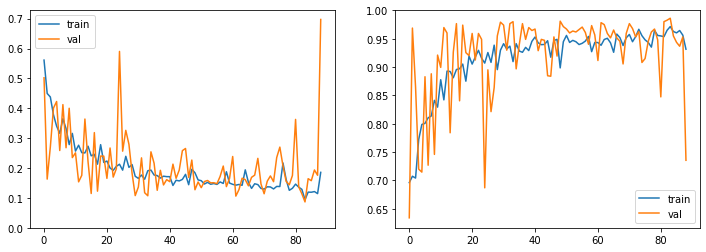

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6615 - accuracy: 0.5868 - precision: 0.9472 - recall: 0.5815 - f1: 0.7038 - specificity: 0.6060 - negative_predictive_value: 0.1066 - matthews_correlation_coefficient: 0.1237 - val_loss: 0.7305 - val_accuracy: 0.4840 - val_precision: 0.9451 - val_recall: 0.4486 - val_f1: 0.6027 - val_specificity: 0.6635 - val_negative_predictive_value: 0.0980 - val_matthews_correlation_coefficient: 0.1145

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11453, saving model to ../models/autoencoders_requirements/pixelation_2020_04_05-13_48_21.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6396 - accuracy: 0.6193 - precision: 0.9683 - recall: 0.6114 - f1: 0.7371 - specificity: 0.6097 - negative_predictive_value: 0.1194 - matthews_correlation_coefficient: 0.1505 - val_loss: 0.6133 - val_accuracy: 0.5716 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.22597
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5428 - accuracy: 0.6829 - precision: 0.9772 - recall: 0.6752 - f1: 0.7931 - specificity: 0.7222 - negative_predictive_value: 0.1569 - matthews_correlation_coefficient: 0.2342 - val_loss: 0.3400 - val_accuracy: 0.8317 - val_precision: 0.9541 - val_recall: 0.8666 - val_f1: 0.9065 - val_specificity: 0.3099 - val_negative_predictive_value: 0.1758 - val_matthews_correlation_coefficient: 0.1538

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.22597
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5405 - accuracy: 0.6987 - precision: 0.9746 - recall: 0.6963 - f1: 0.8077 - specificity: 0.7093 - negative_predictive_value: 0.1557 - matthews_correlation_coefficient: 0.2312 - val_loss: 0.3810 - val_accuracy: 0.7676 - val_precision: 0.9675 - val_recall: 0.7837 - val_f1: 0.8636 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.22597
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5246 - accuracy: 0.7048 - precision: 0.9708 - recall: 0.6944 - f1: 0.8045 - specificity: 0.6979 - negative_predictive_value: 0.1639 - matthews_correlation_coefficient: 0.2336 - val_loss: 0.5125 - val_accuracy: 0.6999 - val_precision: 0.9771 - val_recall: 0.7023 - val_f1: 0.8144 - val_specificity: 0.6050 - val_negative_predictive_value: 0.1477 - val_matthews_correlation_coefficient: 0.2007

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.22597
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5689 - accuracy: 0.6371 - precision: 0.9762 - recall: 0.6302 - f1: 0.7502 - specificity: 0.7167 - negative_predictive_value: 0.1463 - matthews_correlation_coefficient: 0.2104 - val_loss: 0.2656 - val_accuracy: 0.9055 - val_precision: 0.9502 - val_recall: 0.9514 - val_f1: 0.9500 - val_spe

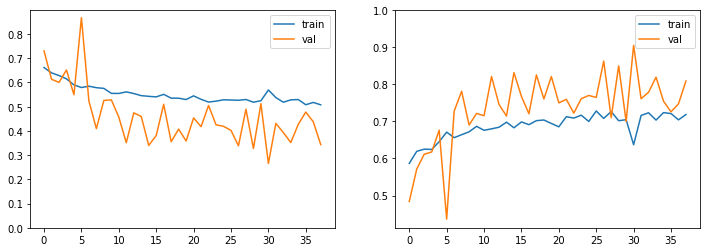

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5686 - accuracy: 0.7111 - precision: 0.9043 - recall: 0.6926 - f1: 0.7751 - specificity: 0.7721 - negative_predictive_value: 0.4481 - matthews_correlation_coefficient: 0.4100 - val_loss: 0.5379 - val_accuracy: 0.7251 - val_precision: 0.8941 - val_recall: 0.6686 - val_f1: 0.7628 - val_specificity: 0.8407 - val_negative_predictive_value: 0.4960 - val_matthews_correlation_coefficient: 0.4437

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.44371, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_04_05-13_54_06.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5559 - accuracy: 0.7117 - precision: 0.9151 - recall: 0.6756 - f1: 0.7724 - specificity: 0.8297 - negative_predictive_value: 0.4758 - matthews_correlation_coefficient: 0.4416 - val_loss: 0.5704 - val_accuracy: 0.7164 - val_preci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5112 - accuracy: 0.7477 - precision: 0.9170 - recall: 0.7233 - f1: 0.8031 - specificity: 0.8223 - negative_predictive_value: 0.5136 - matthews_correlation_coefficient: 0.4839 - val_loss: 0.4948 - val_accuracy: 0.7554 - val_precision: 0.8906 - val_recall: 0.7169 - val_f1: 0.7924 - val_specificity: 0.8212 - val_negative_predictive_value: 0.5305 - val_matthews_correlation_coefficient: 0.4741

Epoch 00015: val_matthews_correlation_coefficient improved from 0.46126 to 0.47412, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_04_05-13_54_06.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5108 - accuracy: 0.7523 - precision: 0.9158 - recall: 0.7301 - f1: 0.8088 - specificity: 0.8069 - negative_predictive_value: 0.5143 - matthews_correlation_coefficient: 0.4800 - val_loss: 0.5174 - val_accuracy: 0.7381 - val_precision: 0.8936 - val_recall: 0.6886 - val_f1: 0.7756 - val


Epoch 00029: val_matthews_correlation_coefficient improved from 0.47587 to 0.47834, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_04_05-13_54_06.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4924 - accuracy: 0.7640 - precision: 0.9138 - recall: 0.7515 - f1: 0.8203 - specificity: 0.7960 - negative_predictive_value: 0.5317 - matthews_correlation_coefficient: 0.4932 - val_loss: 0.5609 - val_accuracy: 0.7303 - val_precision: 0.8992 - val_recall: 0.6704 - val_f1: 0.7663 - val_specificity: 0.8521 - val_negative_predictive_value: 0.5013 - val_matthews_correlation_coefficient: 0.4555

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.47834
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4885 - accuracy: 0.7646 - precision: 0.9170 - recall: 0.7539 - f1: 0.8237 - specificity: 0.8074 - negative_predictive_value: 0.5410 - matthews_correlation_coefficient: 0.5048 - val_loss: 0.56

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4809 - accuracy: 0.7605 - precision: 0.9137 - recall: 0.7381 - f1: 0.8116 - specificity: 0.8073 - negative_predictive_value: 0.5390 - matthews_correlation_coefficient: 0.4957 - val_loss: 0.5005 - val_accuracy: 0.7563 - val_precision: 0.8979 - val_recall: 0.7110 - val_f1: 0.7912 - val_specificity: 0.8382 - val_negative_predictive_value: 0.5327 - val_matthews_correlation_coefficient: 0.4843

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49673
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4800 - accuracy: 0.7651 - precision: 0.9211 - recall: 0.7486 - f1: 0.8220 - specificity: 0.8043 - negative_predictive_value: 0.5288 - matthews_correlation_coefficient: 0.4967 - val_loss: 0.4389 - val_accuracy: 0.8066 - val_precision: 0.8344 - val_recall: 0.8608 - val_f1: 0.8458 - val_specificity: 0.6000 - val_negative_predictive_value: 0.6461 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4689 - accuracy: 0.7740 - precision: 0.9204 - recall: 0.7600 - f1: 0.8292 - specificity: 0.8166 - negative_predictive_value: 0.5496 - matthews_correlation_coefficient: 0.5185 - val_loss: 0.5067 - val_accuracy: 0.7554 - val_precision: 0.8912 - val_recall: 0.7161 - val_f1: 0.7923 - val_specificity: 0.8225 - val_negative_predictive_value: 0.5308 - val_matthews_correlation_coefficient: 0.4748

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.49688
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4615 - accuracy: 0.7770 - precision: 0.9216 - recall: 0.7633 - f1: 0.8302 - specificity: 0.8110 - negative_predictive_value: 0.5502 - matthews_correlation_coefficient: 0.5197 - val_loss: 0.5501 - val_accuracy: 0.7407 - val_precision: 0.9018 - val_recall: 0.6853 - val_f1: 0.7762 - val_specificity: 0.8568 - val_negative_predictive_value: 0.5163 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.51369
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4521 - accuracy: 0.7742 - precision: 0.9169 - recall: 0.7672 - f1: 0.8312 - specificity: 0.8068 - negative_predictive_value: 0.5544 - matthews_correlation_coefficient: 0.5174 - val_loss: 0.5270 - val_accuracy: 0.7424 - val_precision: 0.8983 - val_recall: 0.6902 - val_f1: 0.7782 - val_specificity: 0.8483 - val_negative_predictive_value: 0.5170 - val_matthews_correlation_coefficient: 0.4707

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.51369
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4550 - accuracy: 0.7738 - precision: 0.9194 - recall: 0.7636 - f1: 0.8289 - specificity: 0.8068 - negative_predictive_value: 0.5553 - matthews_correlation_coefficient: 0.5174 - val_loss: 0.5560 - val_accuracy: 0.7398 - val_precision: 0.8995 - val_recall: 0.6851 - val_f1: 0.7755 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4456 - accuracy: 0.7848 - precision: 0.9151 - recall: 0.7785 - f1: 0.8364 - specificity: 0.7985 - negative_predictive_value: 0.5596 - matthews_correlation_coefficient: 0.5229 - val_loss: 0.4895 - val_accuracy: 0.7858 - val_precision: 0.8939 - val_recall: 0.7573 - val_f1: 0.8177 - val_specificity: 0.8177 - val_negative_predictive_value: 0.5738 - val_matthews_correlation_coefficient: 0.5166

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.53025
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4449 - accuracy: 0.7803 - precision: 0.9208 - recall: 0.7701 - f1: 0.8346 - specificity: 0.8229 - negative_predictive_value: 0.5653 - matthews_correlation_coefficient: 0.5344 - val_loss: 0.5426 - val_accuracy: 0.7407 - val_precision: 0.9031 - val_recall: 0.6840 - val_f1: 0.7759 - val_specificity: 0.8593 - val_negative_predictive_value: 0.5147 - val_matthews_correlation_coefficie

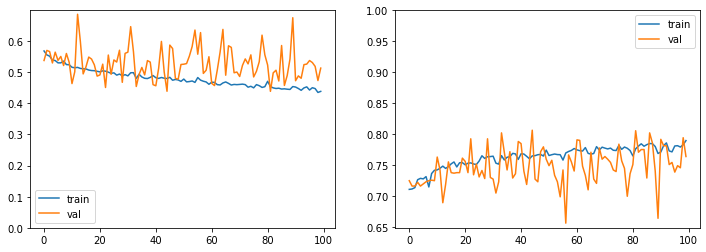

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6583 - accuracy: 0.5484 - precision: 0.8691 - recall: 0.4976 - f1: 0.6184 - specificity: 0.7227 - negative_predictive_value: 0.2921 - matthews_correlation_coefficient: 0.1906 - val_loss: 0.5877 - val_accuracy: 0.6479 - val_precision: 0.7940 - val_recall: 0.6836 - val_f1: 0.7314 - val_specificity: 0.4550 - val_negative_predictive_value: 0.3099 - val_matthews_correlation_coefficient: 0.1466

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.14655, saving model to ../models/autoencoders_requirements/eyes_closed_2020_04_05-14_09_00.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6608 - accuracy: 0.5501 - precision: 0.8694 - recall: 0.4972 - f1: 0.6149 - specificity: 0.7428 - negative_predictive_value: 0.3055 - matthews_correlation_coefficient: 0.2032 - val_loss: 0.6737 - val_accuracy: 0.5317 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6147 - accuracy: 0.6425 - precision: 0.8764 - recall: 0.6177 - f1: 0.7169 - specificity: 0.7078 - negative_predictive_value: 0.3597 - matthews_correlation_coefficient: 0.2821 - val_loss: 0.6027 - val_accuracy: 0.6626 - val_precision: 0.8438 - val_recall: 0.6459 - val_f1: 0.7297 - val_specificity: 0.6297 - val_negative_predictive_value: 0.3566 - val_matthews_correlation_coefficient: 0.2616

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.28334
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6182 - accuracy: 0.6427 - precision: 0.8905 - recall: 0.6194 - f1: 0.7194 - specificity: 0.7282 - negative_predictive_value: 0.3652 - matthews_correlation_coefficient: 0.2950 - val_loss: 0.6047 - val_accuracy: 0.6600 - val_precision: 0.8494 - val_recall: 0.6349 - val_f1: 0.7245 - val_specificity: 0.6563 - val_negative_predictive_value: 0.3605 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.31930
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5692 - accuracy: 0.6941 - precision: 0.8941 - recall: 0.6917 - f1: 0.7714 - specificity: 0.7103 - negative_predictive_value: 0.4063 - matthews_correlation_coefficient: 0.3440 - val_loss: 0.7332 - val_accuracy: 0.5915 - val_precision: 0.8551 - val_recall: 0.5277 - val_f1: 0.6474 - val_specificity: 0.7287 - val_negative_predictive_value: 0.3249 - val_matthews_correlation_coefficient: 0.2412

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.31930
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5696 - accuracy: 0.6926 - precision: 0.8972 - recall: 0.6817 - f1: 0.7678 - specificity: 0.7286 - negative_predictive_value: 0.4102 - matthews_correlation_coefficient: 0.3521 - val_loss: 0.5117 - val_accuracy: 0.7554 - val_precision: 0.8409 - val_recall: 0.8519 - val_f1: 0.8445 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.32783
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5526 - accuracy: 0.7121 - precision: 0.9007 - recall: 0.7084 - f1: 0.7881 - specificity: 0.7307 - negative_predictive_value: 0.4332 - matthews_correlation_coefficient: 0.3809 - val_loss: 0.6801 - val_accuracy: 0.6141 - val_precision: 0.8642 - val_recall: 0.5536 - val_f1: 0.6697 - val_specificity: 0.7392 - val_negative_predictive_value: 0.3394 - val_matthews_correlation_coefficient: 0.2704

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.32783
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5527 - accuracy: 0.7063 - precision: 0.8990 - recall: 0.6984 - f1: 0.7804 - specificity: 0.7133 - negative_predictive_value: 0.4168 - matthews_correlation_coefficient: 0.3597 - val_loss: 0.6223 - val_accuracy: 0.6444 - val_precision: 0.8748 - val_recall: 0.5882 - val_f1: 0.6983 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.34770
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5321 - accuracy: 0.7208 - precision: 0.8965 - recall: 0.7090 - f1: 0.7873 - specificity: 0.7352 - negative_predictive_value: 0.4383 - matthews_correlation_coefficient: 0.3827 - val_loss: 0.6223 - val_accuracy: 0.6592 - val_precision: 0.8684 - val_recall: 0.6138 - val_f1: 0.7159 - val_specificity: 0.7303 - val_negative_predictive_value: 0.3725 - val_matthews_correlation_coefficient: 0.3142

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.34770
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5431 - accuracy: 0.7100 - precision: 0.9027 - recall: 0.7036 - f1: 0.7833 - specificity: 0.7541 - negative_predictive_value: 0.4322 - matthews_correlation_coefficient: 0.3904 - val_loss: 0.7209 - val_accuracy: 0.6167 - val_precision: 0.8785 - val_recall: 0.5447 - val_f1: 0.6673 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.34770
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5278 - accuracy: 0.7262 - precision: 0.9073 - recall: 0.7186 - f1: 0.7953 - specificity: 0.7463 - negative_predictive_value: 0.4489 - matthews_correlation_coefficient: 0.4043 - val_loss: 0.6601 - val_accuracy: 0.6592 - val_precision: 0.8667 - val_recall: 0.6158 - val_f1: 0.7156 - val_specificity: 0.7214 - val_negative_predictive_value: 0.3728 - val_matthews_correlation_coefficient: 0.3104

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.34770
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5246 - accuracy: 0.7249 - precision: 0.9015 - recall: 0.7129 - f1: 0.7899 - specificity: 0.7439 - negative_predictive_value: 0.4436 - matthews_correlation_coefficient: 0.3972 - val_loss: 0.6098 - val_accuracy: 0.6600 - val_precision: 0.8689 - val_recall: 0.6133 - val_f1: 0.7152 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5188 - accuracy: 0.7226 - precision: 0.9104 - recall: 0.7110 - f1: 0.7924 - specificity: 0.7635 - negative_predictive_value: 0.4483 - matthews_correlation_coefficient: 0.4095 - val_loss: 0.6511 - val_accuracy: 0.6418 - val_precision: 0.8690 - val_recall: 0.5894 - val_f1: 0.6975 - val_specificity: 0.7362 - val_negative_predictive_value: 0.3593 - val_matthews_correlation_coefficient: 0.2990

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.35959
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5203 - accuracy: 0.7241 - precision: 0.9095 - recall: 0.7183 - f1: 0.7971 - specificity: 0.7458 - negative_predictive_value: 0.4385 - matthews_correlation_coefficient: 0.3985 - val_loss: 0.6282 - val_accuracy: 0.6635 - val_precision: 0.8809 - val_recall: 0.6092 - val_f1: 0.7149 - val_specificity: 0.7647 - val_negative_predictive_value: 0.3822 - val_matthews_correlation_coefficie

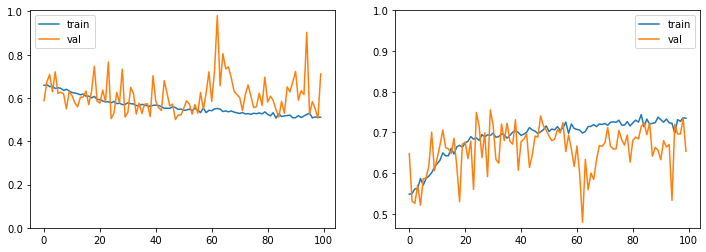

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5119 - accuracy: 0.7315 - precision: 0.8068 - recall: 0.7023 - f1: 0.7205 - specificity: 0.7694 - negative_predictive_value: 0.7102 - matthews_correlation_coefficient: 0.4907 - val_loss: 0.5821 - val_accuracy: 0.6696 - val_precision: 0.8919 - val_recall: 0.4479 - val_f1: 0.5876 - val_specificity: 0.9197 - val_negative_predictive_value: 0.5590 - val_matthews_correlation_coefficient: 0.4325

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.43247, saving model to ../models/autoencoders_requirements/varied_background_2020_04_05-14_23_48.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4449 - accuracy: 0.7692 - precision: 0.8317 - recall: 0.7626 - f1: 0.7803 - specificity: 0.7890 - negative_predictive_value: 0.7294 - matthews_correlation_coefficient: 0.5570 - val_loss: 0.4122 - val_accuracy: 0.7780 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3733 - accuracy: 0.8137 - precision: 0.8666 - recall: 0.8071 - f1: 0.8244 - specificity: 0.8341 - negative_predictive_value: 0.7813 - matthews_correlation_coefficient: 0.6438 - val_loss: 0.3722 - val_accuracy: 0.8005 - val_precision: 0.7823 - val_recall: 0.8366 - val_f1: 0.8049 - val_specificity: 0.7033 - val_negative_predictive_value: 0.7701 - val_matthews_correlation_coefficient: 0.5727

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.61608
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3631 - accuracy: 0.8213 - precision: 0.8706 - recall: 0.8146 - f1: 0.8340 - specificity: 0.8427 - negative_predictive_value: 0.7790 - matthews_correlation_coefficient: 0.6531 - val_loss: 0.3655 - val_accuracy: 0.8161 - val_precision: 0.8444 - val_recall: 0.7754 - val_f1: 0.8059 - val_specificity: 0.8152 - val_negative_predictive_value: 0.7355 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3354 - accuracy: 0.8397 - precision: 0.8912 - recall: 0.8205 - f1: 0.8471 - specificity: 0.8660 - negative_predictive_value: 0.7890 - matthews_correlation_coefficient: 0.6847 - val_loss: 0.3682 - val_accuracy: 0.8109 - val_precision: 0.7981 - val_recall: 0.8290 - val_f1: 0.8100 - val_specificity: 0.7342 - val_negative_predictive_value: 0.7760 - val_matthews_correlation_coefficient: 0.5952

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.63450
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3278 - accuracy: 0.8395 - precision: 0.8757 - recall: 0.8268 - f1: 0.8456 - specificity: 0.8502 - negative_predictive_value: 0.8005 - matthews_correlation_coefficient: 0.6780 - val_loss: 0.3859 - val_accuracy: 0.7997 - val_precision: 0.8794 - val_recall: 0.7083 - val_f1: 0.7817 - val_specificity: 0.8677 - val_negative_predictive_value: 0.6903 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3174 - accuracy: 0.8462 - precision: 0.8982 - recall: 0.8269 - f1: 0.8552 - specificity: 0.8789 - negative_predictive_value: 0.8004 - matthews_correlation_coefficient: 0.7017 - val_loss: 0.3317 - val_accuracy: 0.8335 - val_precision: 0.8583 - val_recall: 0.7919 - val_f1: 0.8214 - val_specificity: 0.8345 - val_negative_predictive_value: 0.7551 - val_matthews_correlation_coefficient: 0.6466

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.64893
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3136 - accuracy: 0.8440 - precision: 0.8837 - recall: 0.8262 - f1: 0.8481 - specificity: 0.8702 - negative_predictive_value: 0.7999 - matthews_correlation_coefficient: 0.6913 - val_loss: 0.3531 - val_accuracy: 0.8231 - val_precision: 0.8392 - val_recall: 0.7939 - val_f1: 0.8132 - val_specificity: 0.8099 - val_negative_predictive_value: 0.7551 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3038 - accuracy: 0.8534 - precision: 0.8956 - recall: 0.8451 - f1: 0.8650 - specificity: 0.8776 - negative_predictive_value: 0.8086 - matthews_correlation_coefficient: 0.7131 - val_loss: 0.3459 - val_accuracy: 0.8352 - val_precision: 0.8823 - val_recall: 0.7686 - val_f1: 0.8195 - val_specificity: 0.8663 - val_negative_predictive_value: 0.7412 - val_matthews_correlation_coefficient: 0.6558

Epoch 00056: val_matthews_correlation_coefficient did not improve from 0.67032
Epoch 57/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2922 - accuracy: 0.8586 - precision: 0.9010 - recall: 0.8325 - f1: 0.8613 - specificity: 0.8869 - negative_predictive_value: 0.8106 - matthews_correlation_coefficient: 0.7170 - val_loss: 0.3227 - val_accuracy: 0.8465 - val_precision: 0.8627 - val_recall: 0.8103 - val_f1: 0.8340 - val_specificity: 0.8382 - val_negative_predictive_value: 0.7741 - val_matthews_correlation_coefficie


Epoch 00070: val_matthews_correlation_coefficient did not improve from 0.68488
Epoch 71/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2860 - accuracy: 0.8599 - precision: 0.9023 - recall: 0.8463 - f1: 0.8691 - specificity: 0.8836 - negative_predictive_value: 0.8158 - matthews_correlation_coefficient: 0.7235 - val_loss: 0.3159 - val_accuracy: 0.8508 - val_precision: 0.8702 - val_recall: 0.8121 - val_f1: 0.8385 - val_specificity: 0.8463 - val_negative_predictive_value: 0.7761 - val_matthews_correlation_coefficient: 0.6791

Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.68488
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2824 - accuracy: 0.8627 - precision: 0.9065 - recall: 0.8466 - f1: 0.8702 - specificity: 0.8820 - negative_predictive_value: 0.8099 - matthews_correlation_coefficient: 0.7238 - val_loss: 0.3241 - val_accuracy: 0.8569 - val_precision: 0.8668 - val_recall: 0.8275 - val_f1: 0.8454 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2856 - accuracy: 0.8627 - precision: 0.8993 - recall: 0.8410 - f1: 0.8652 - specificity: 0.8885 - negative_predictive_value: 0.8165 - matthews_correlation_coefficient: 0.7241 - val_loss: 0.3316 - val_accuracy: 0.8448 - val_precision: 0.8729 - val_recall: 0.8519 - val_f1: 0.8605 - val_specificity: 0.8149 - val_negative_predictive_value: 0.7852 - val_matthews_correlation_coefficient: 0.6622

Epoch 00085: val_matthews_correlation_coefficient did not improve from 0.70674
Epoch 86/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2748 - accuracy: 0.8677 - precision: 0.9102 - recall: 0.8537 - f1: 0.8768 - specificity: 0.8907 - negative_predictive_value: 0.8242 - matthews_correlation_coefficient: 0.7390 - val_loss: 0.3250 - val_accuracy: 0.8500 - val_precision: 0.8826 - val_recall: 0.7965 - val_f1: 0.8356 - val_specificity: 0.8638 - val_negative_predictive_value: 0.7656 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2627 - accuracy: 0.8735 - precision: 0.9147 - recall: 0.8602 - f1: 0.8833 - specificity: 0.8954 - negative_predictive_value: 0.8291 - matthews_correlation_coefficient: 0.7493 - val_loss: 0.3102 - val_accuracy: 0.8569 - val_precision: 0.8428 - val_recall: 0.8548 - val_f1: 0.8476 - val_specificity: 0.8015 - val_negative_predictive_value: 0.8153 - val_matthews_correlation_coefficient: 0.6842

Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.70674

   Final Accuracy:  85.69%
  Final Precision:  86.80%
     Final Recall:  88.00%
  Final F-measure:  87.39%
Final Specificity:  82.70%
        Final NPV:  84.21%
        Final MCC:  70.86%
[[416  87]
 [ 78 572]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       503
           1       0.87      0.88      0.87       650

    accuracy                           0.86      1153
   macro avg       0.86      0

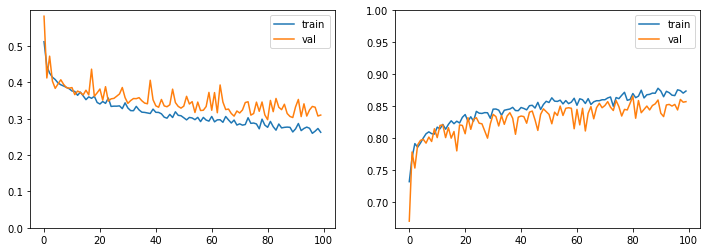

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5922 - accuracy: 0.7015 - precision: 0.8983 - recall: 0.6843 - f1: 0.7727 - specificity: 0.7626 - negative_predictive_value: 0.4370 - matthews_correlation_coefficient: 0.3848 - val_loss: 0.5399 - val_accuracy: 0.7025 - val_precision: 0.8759 - val_recall: 0.6659 - val_f1: 0.7536 - val_specificity: 0.7596 - val_negative_predictive_value: 0.4504 - val_matthews_correlation_coefficient: 0.3704

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.37043, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_04_05-14_38_34.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5730 - accuracy: 0.7076 - precision: 0.9078 - recall: 0.6802 - f1: 0.7743 - specificity: 0.7819 - negative_predictive_value: 0.4431 - matthews_correlation_coefficient: 0.4020 - val_loss: 0.5616 - val_accuracy: 0.7016 - val_precisi


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.38892
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5593 - accuracy: 0.7030 - precision: 0.9111 - recall: 0.6692 - f1: 0.7679 - specificity: 0.8051 - negative_predictive_value: 0.4430 - matthews_correlation_coefficient: 0.4091 - val_loss: 0.6125 - val_accuracy: 0.6722 - val_precision: 0.8933 - val_recall: 0.6071 - val_f1: 0.7205 - val_specificity: 0.8192 - val_negative_predictive_value: 0.4246 - val_matthews_correlation_coefficient: 0.3658

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.38892
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5598 - accuracy: 0.7056 - precision: 0.9137 - recall: 0.6764 - f1: 0.7736 - specificity: 0.7946 - negative_predictive_value: 0.4384 - matthews_correlation_coefficient: 0.4052 - val_loss: 0.5556 - val_accuracy: 0.6982 - val_precision: 0.8863 - val_recall: 0.6501 - val_f1: 0.7471 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5554 - accuracy: 0.7059 - precision: 0.9168 - recall: 0.6732 - f1: 0.7727 - specificity: 0.8224 - negative_predictive_value: 0.4476 - matthews_correlation_coefficient: 0.4224 - val_loss: 0.5324 - val_accuracy: 0.7147 - val_precision: 0.8794 - val_recall: 0.6818 - val_f1: 0.7651 - val_specificity: 0.7553 - val_negative_predictive_value: 0.4604 - val_matthews_correlation_coefficient: 0.3832

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39354
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5548 - accuracy: 0.7098 - precision: 0.9156 - recall: 0.6798 - f1: 0.7767 - specificity: 0.8071 - negative_predictive_value: 0.4462 - matthews_correlation_coefficient: 0.4175 - val_loss: 0.5307 - val_accuracy: 0.7121 - val_precision: 0.8781 - val_recall: 0.6777 - val_f1: 0.7617 - val_specificity: 0.7673 - val_negative_predictive_value: 0.4607 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39731
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5510 - accuracy: 0.7117 - precision: 0.9188 - recall: 0.6753 - f1: 0.7757 - specificity: 0.8089 - negative_predictive_value: 0.4447 - matthews_correlation_coefficient: 0.4187 - val_loss: 0.5362 - val_accuracy: 0.7095 - val_precision: 0.8814 - val_recall: 0.6693 - val_f1: 0.7578 - val_specificity: 0.7787 - val_negative_predictive_value: 0.4573 - val_matthews_correlation_coefficient: 0.3872

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39731
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5472 - accuracy: 0.7154 - precision: 0.9106 - recall: 0.6800 - f1: 0.7753 - specificity: 0.8111 - negative_predictive_value: 0.4514 - matthews_correlation_coefficient: 0.4191 - val_loss: 0.5689 - val_accuracy: 0.6947 - val_precision: 0.8880 - val_recall: 0.6433 - val_f1: 0.7436 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40165
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5402 - accuracy: 0.7210 - precision: 0.9211 - recall: 0.6930 - f1: 0.7873 - specificity: 0.8038 - negative_predictive_value: 0.4586 - matthews_correlation_coefficient: 0.4329 - val_loss: 0.5492 - val_accuracy: 0.7181 - val_precision: 0.8784 - val_recall: 0.6843 - val_f1: 0.7660 - val_specificity: 0.7673 - val_negative_predictive_value: 0.4678 - val_matthews_correlation_coefficient: 0.3930

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40165
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5384 - accuracy: 0.7234 - precision: 0.9224 - recall: 0.6942 - f1: 0.7876 - specificity: 0.8074 - negative_predictive_value: 0.4605 - matthews_correlation_coefficient: 0.4363 - val_loss: 0.5772 - val_accuracy: 0.6817 - val_precision: 0.8870 - val_recall: 0.6259 - val_f1: 0.7301 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40165
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5372 - accuracy: 0.7197 - precision: 0.9191 - recall: 0.6921 - f1: 0.7862 - specificity: 0.8068 - negative_predictive_value: 0.4562 - matthews_correlation_coefficient: 0.4309 - val_loss: 0.5249 - val_accuracy: 0.7155 - val_precision: 0.8812 - val_recall: 0.6795 - val_f1: 0.7636 - val_specificity: 0.7758 - val_negative_predictive_value: 0.4661 - val_matthews_correlation_coefficient: 0.3951

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40165
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5321 - accuracy: 0.7249 - precision: 0.9222 - recall: 0.6982 - f1: 0.7904 - specificity: 0.8148 - negative_predictive_value: 0.4712 - matthews_correlation_coefficient: 0.4470 - val_loss: 0.5824 - val_accuracy: 0.6860 - val_precision: 0.8916 - val_recall: 0.6284 - val_f1: 0.7344 - val_spe

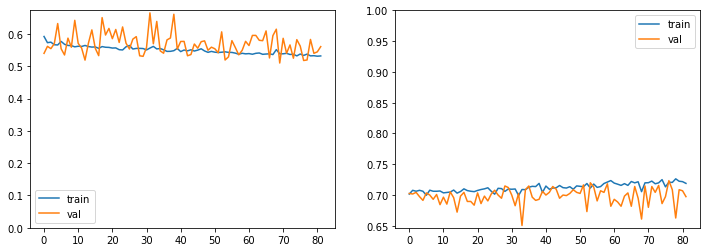

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6002 - accuracy: 0.6740 - precision: 0.7438 - recall: 0.6415 - f1: 0.6580 - specificity: 0.7113 - negative_predictive_value: 0.6476 - matthews_correlation_coefficient: 0.3701 - val_loss: 0.5271 - val_accuracy: 0.7537 - val_precision: 0.6986 - val_recall: 0.8799 - val_f1: 0.7727 - val_specificity: 0.5614 - val_negative_predictive_value: 0.7966 - val_matthews_correlation_coefficient: 0.4928

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.49284, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_04_05-14_50_45.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5459 - accuracy: 0.7271 - precision: 0.7542 - recall: 0.7598 - f1: 0.7445 - specificity: 0.6978 - negative_predictive_value: 0.7226 - matthews_correlation_coefficient: 0.4665 - val_loss: 0.4969 - val_accuracy: 0.7476 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4407 - accuracy: 0.7807 - precision: 0.7894 - recall: 0.8077 - f1: 0.7925 - specificity: 0.7446 - negative_predictive_value: 0.7649 - matthews_correlation_coefficient: 0.5598 - val_loss: 0.4685 - val_accuracy: 0.7710 - val_precision: 0.7120 - val_recall: 0.8853 - val_f1: 0.7843 - val_specificity: 0.5856 - val_negative_predictive_value: 0.8101 - val_matthews_correlation_coefficient: 0.5214

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.56664
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4641 - accuracy: 0.7764 - precision: 0.8017 - recall: 0.7997 - f1: 0.7908 - specificity: 0.7565 - negative_predictive_value: 0.7696 - matthews_correlation_coefficient: 0.5630 - val_loss: 0.4288 - val_accuracy: 0.7832 - val_precision: 0.7244 - val_recall: 0.8852 - val_f1: 0.7922 - val_specificity: 0.6163 - val_negative_predictive_value: 0.8205 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4303 - accuracy: 0.7824 - precision: 0.8055 - recall: 0.7883 - f1: 0.7884 - specificity: 0.7787 - negative_predictive_value: 0.7610 - matthews_correlation_coefficient: 0.5681 - val_loss: 0.4219 - val_accuracy: 0.7944 - val_precision: 0.8189 - val_recall: 0.7468 - val_f1: 0.7739 - val_specificity: 0.8312 - val_negative_predictive_value: 0.7469 - val_matthews_correlation_coefficient: 0.5709

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.57711
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4144 - accuracy: 0.7900 - precision: 0.8118 - recall: 0.8030 - f1: 0.8017 - specificity: 0.7692 - negative_predictive_value: 0.7641 - matthews_correlation_coefficient: 0.5755 - val_loss: 0.4101 - val_accuracy: 0.8005 - val_precision: 0.7804 - val_recall: 0.8162 - val_f1: 0.7921 - val_specificity: 0.7621 - val_negative_predictive_value: 0.7944 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.58744
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4089 - accuracy: 0.7957 - precision: 0.8312 - recall: 0.7997 - f1: 0.8061 - specificity: 0.7977 - negative_predictive_value: 0.7772 - matthews_correlation_coefficient: 0.6024 - val_loss: 0.4149 - val_accuracy: 0.8014 - val_precision: 0.7627 - val_recall: 0.8530 - val_f1: 0.8012 - val_specificity: 0.6951 - val_negative_predictive_value: 0.7882 - val_matthews_correlation_coefficient: 0.5759

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.58744
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3979 - accuracy: 0.8028 - precision: 0.8204 - recall: 0.8085 - f1: 0.8087 - specificity: 0.7899 - negative_predictive_value: 0.7799 - matthews_correlation_coefficient: 0.5992 - val_loss: 0.3985 - val_accuracy: 0.8005 - val_precision: 0.7794 - val_recall: 0.8196 - val_f1: 0.7934 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3906 - accuracy: 0.8061 - precision: 0.8346 - recall: 0.8108 - f1: 0.8139 - specificity: 0.7970 - negative_predictive_value: 0.7820 - matthews_correlation_coefficient: 0.6132 - val_loss: 0.3938 - val_accuracy: 0.8109 - val_precision: 0.8076 - val_recall: 0.7894 - val_f1: 0.7932 - val_specificity: 0.8123 - val_negative_predictive_value: 0.7864 - val_matthews_correlation_coefficient: 0.5971

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.60455
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3909 - accuracy: 0.8095 - precision: 0.8313 - recall: 0.8208 - f1: 0.8190 - specificity: 0.7944 - negative_predictive_value: 0.7870 - matthews_correlation_coefficient: 0.6181 - val_loss: 0.4094 - val_accuracy: 0.8075 - val_precision: 0.7769 - val_recall: 0.8420 - val_f1: 0.8033 - val_specificity: 0.7427 - val_negative_predictive_value: 0.8137 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.61424
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3858 - accuracy: 0.8171 - precision: 0.8366 - recall: 0.8193 - f1: 0.8209 - specificity: 0.8087 - negative_predictive_value: 0.7915 - matthews_correlation_coefficient: 0.6277 - val_loss: 0.4094 - val_accuracy: 0.7997 - val_precision: 0.8186 - val_recall: 0.7605 - val_f1: 0.7828 - val_specificity: 0.8054 - val_negative_predictive_value: 0.7317 - val_matthews_correlation_coefficient: 0.5844

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.61424
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3823 - accuracy: 0.8152 - precision: 0.8405 - recall: 0.8261 - f1: 0.8265 - specificity: 0.8101 - negative_predictive_value: 0.7979 - matthews_correlation_coefficient: 0.6369 - val_loss: 0.4184 - val_accuracy: 0.8057 - val_precision: 0.8106 - val_recall: 0.7892 - val_f1: 0.7933 - val_spe


Epoch 00087: val_matthews_correlation_coefficient improved from 0.61424 to 0.61916, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_04_05-14_50_45.h5
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3592 - accuracy: 0.8336 - precision: 0.8547 - recall: 0.8397 - f1: 0.8421 - specificity: 0.8237 - negative_predictive_value: 0.8096 - matthews_correlation_coefficient: 0.6635 - val_loss: 0.4225 - val_accuracy: 0.7962 - val_precision: 0.7507 - val_recall: 0.8621 - val_f1: 0.7977 - val_specificity: 0.6737 - val_negative_predictive_value: 0.8028 - val_matthews_correlation_coefficient: 0.5704

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.61916
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3697 - accuracy: 0.8226 - precision: 0.8479 - recall: 0.8214 - f1: 0.8290 - specificity: 0.8142 - negative_predictive_value: 0.7945 - matthews_correlation_coefficient: 0.6404 - val_lo

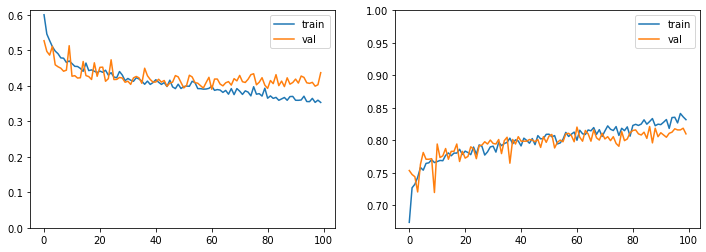

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6376 - accuracy: 0.5249 - precision: 0.8937 - recall: 0.4503 - f1: 0.5880 - specificity: 0.7973 - negative_predictive_value: 0.2837 - matthews_correlation_coefficient: 0.2144 - val_loss: 0.6779 - val_accuracy: 0.4701 - val_precision: 0.9492 - val_recall: 0.3642 - val_f1: 0.5153 - val_specificity: 0.9042 - val_negative_predictive_value: 0.2715 - val_matthews_correlation_coefficient: 0.2417

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24172, saving model to ../models/autoencoders_requirements/red_eyes_2020_04_05-15_05_38.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6247 - accuracy: 0.5334 - precision: 0.9139 - recall: 0.4547 - f1: 0.5925 - specificity: 0.8145 - negative_predictive_value: 0.2912 - matthews_correlation_coefficient: 0.2348 - val_loss: 0.6665 - val_accuracy: 0.4892 - val_precision: 0


Epoch 00014: val_matthews_correlation_coefficient improved from 0.36454 to 0.39547, saving model to ../models/autoencoders_requirements/red_eyes_2020_04_05-15_05_38.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5790 - accuracy: 0.6252 - precision: 0.9204 - recall: 0.5777 - f1: 0.7024 - specificity: 0.7969 - negative_predictive_value: 0.3400 - matthews_correlation_coefficient: 0.3108 - val_loss: 0.5972 - val_accuracy: 0.5872 - val_precision: 0.9518 - val_recall: 0.5131 - val_f1: 0.6586 - val_specificity: 0.8860 - val_negative_predictive_value: 0.3238 - val_matthews_correlation_coefficient: 0.3299

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39547
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5670 - accuracy: 0.6484 - precision: 0.9214 - recall: 0.6073 - f1: 0.7240 - specificity: 0.8010 - negative_predictive_value: 0.3587 - matthews_correlation_coefficient: 0.3362 - val_loss: 0.5727 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5462 - accuracy: 0.6870 - precision: 0.9158 - recall: 0.6658 - f1: 0.7612 - specificity: 0.7611 - negative_predictive_value: 0.3975 - matthews_correlation_coefficient: 0.3653 - val_loss: 0.6215 - val_accuracy: 0.6002 - val_precision: 0.9451 - val_recall: 0.5333 - val_f1: 0.6752 - val_specificity: 0.8754 - val_negative_predictive_value: 0.3293 - val_matthews_correlation_coefficient: 0.3333

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39649
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5379 - accuracy: 0.6926 - precision: 0.9182 - recall: 0.6609 - f1: 0.7599 - specificity: 0.7849 - negative_predictive_value: 0.4090 - matthews_correlation_coefficient: 0.3805 - val_loss: 0.5447 - val_accuracy: 0.6860 - val_precision: 0.9415 - val_recall: 0.6495 - val_f1: 0.7640 - val_specificity: 0.8304 - val_negative_predictive_value: 0.3845 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43243
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5182 - accuracy: 0.7148 - precision: 0.9270 - recall: 0.6970 - f1: 0.7883 - specificity: 0.8041 - negative_predictive_value: 0.4271 - matthews_correlation_coefficient: 0.4174 - val_loss: 0.5084 - val_accuracy: 0.7441 - val_precision: 0.9177 - val_recall: 0.7529 - val_f1: 0.8233 - val_specificity: 0.7161 - val_negative_predictive_value: 0.4297 - val_matthews_correlation_coefficient: 0.4019

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43243
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5103 - accuracy: 0.7193 - precision: 0.9307 - recall: 0.6946 - f1: 0.7891 - specificity: 0.7967 - negative_predictive_value: 0.4225 - matthews_correlation_coefficient: 0.4150 - val_loss: 0.5044 - val_accuracy: 0.7259 - val_precision: 0.9159 - val_recall: 0.7289 - val_f1: 0.8083 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43243
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4962 - accuracy: 0.7302 - precision: 0.9169 - recall: 0.7131 - f1: 0.7965 - specificity: 0.7821 - negative_predictive_value: 0.4341 - matthews_correlation_coefficient: 0.4153 - val_loss: 0.4583 - val_accuracy: 0.7641 - val_precision: 0.8943 - val_recall: 0.8044 - val_f1: 0.8442 - val_specificity: 0.6088 - val_negative_predictive_value: 0.4523 - val_matthews_correlation_coefficient: 0.3765

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.43243
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4986 - accuracy: 0.7284 - precision: 0.9253 - recall: 0.7162 - f1: 0.7987 - specificity: 0.7869 - negative_predictive_value: 0.4461 - matthews_correlation_coefficient: 0.4283 - val_loss: 0.6620 - val_accuracy: 0.6297 - val_precision: 0.9536 - val_recall: 0.5694 - val_f1: 0.7067 - val_spe

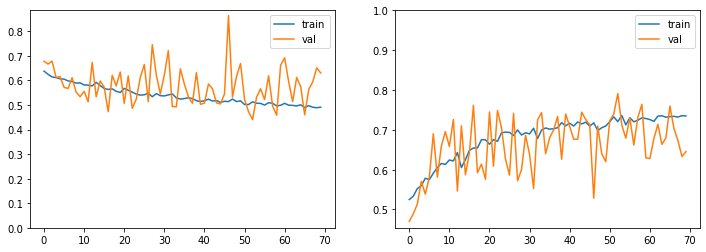

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4754 - accuracy: 0.7512 - precision: 0.8747 - recall: 0.7351 - f1: 0.7909 - specificity: 0.7876 - negative_predictive_value: 0.6028 - matthews_correlation_coefficient: 0.4999 - val_loss: 0.4819 - val_accuracy: 0.7311 - val_precision: 0.8732 - val_recall: 0.6574 - val_f1: 0.7461 - val_specificity: 0.8567 - val_negative_predictive_value: 0.5720 - val_matthews_correlation_coefficient: 0.4770

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.47698, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_04_05-15_16_14.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4348 - accuracy: 0.7785 - precision: 0.8926 - recall: 0.7664 - f1: 0.8204 - specificity: 0.8186 - negative_predictive_value: 0.6306 - matthews_correlation_coefficient: 0.5518 - val_loss: 0.4655 - val_accuracy: 0.7441 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3954 - accuracy: 0.8069 - precision: 0.9037 - recall: 0.8014 - f1: 0.8439 - specificity: 0.8200 - negative_predictive_value: 0.6627 - matthews_correlation_coefficient: 0.5940 - val_loss: 0.3971 - val_accuracy: 0.8040 - val_precision: 0.8626 - val_recall: 0.7916 - val_f1: 0.8223 - val_specificity: 0.7777 - val_negative_predictive_value: 0.6545 - val_matthews_correlation_coefficient: 0.5683

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.57522
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3873 - accuracy: 0.8137 - precision: 0.9043 - recall: 0.8116 - f1: 0.8500 - specificity: 0.8265 - negative_predictive_value: 0.6768 - matthews_correlation_coefficient: 0.6088 - val_loss: 0.3867 - val_accuracy: 0.8222 - val_precision: 0.8678 - val_recall: 0.8120 - val_f1: 0.8372 - val_specificity: 0.7809 - val_negative_predictive_value: 0.6785 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3611 - accuracy: 0.8354 - precision: 0.9098 - recall: 0.8422 - f1: 0.8713 - specificity: 0.8196 - negative_predictive_value: 0.7114 - matthews_correlation_coefficient: 0.6402 - val_loss: 0.3617 - val_accuracy: 0.8317 - val_precision: 0.8210 - val_recall: 0.8924 - val_f1: 0.8536 - val_specificity: 0.6353 - val_negative_predictive_value: 0.7639 - val_matthews_correlation_coefficient: 0.5816

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.61329
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3626 - accuracy: 0.8356 - precision: 0.9082 - recall: 0.8453 - f1: 0.8714 - specificity: 0.8274 - negative_predictive_value: 0.7228 - matthews_correlation_coefficient: 0.6501 - val_loss: 0.3958 - val_accuracy: 0.8170 - val_precision: 0.8868 - val_recall: 0.7813 - val_f1: 0.8293 - val_specificity: 0.8241 - val_negative_predictive_value: 0.6509 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3382 - accuracy: 0.8521 - precision: 0.9040 - recall: 0.8596 - f1: 0.8786 - specificity: 0.8245 - negative_predictive_value: 0.7423 - matthews_correlation_coefficient: 0.6705 - val_loss: 0.3883 - val_accuracy: 0.8161 - val_precision: 0.8909 - val_recall: 0.7783 - val_f1: 0.8287 - val_specificity: 0.8295 - val_negative_predictive_value: 0.6500 - val_matthews_correlation_coefficient: 0.5993

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.64552
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3586 - accuracy: 0.8358 - precision: 0.9156 - recall: 0.8363 - f1: 0.8671 - specificity: 0.8408 - negative_predictive_value: 0.7325 - matthews_correlation_coefficient: 0.6609 - val_loss: 0.3510 - val_accuracy: 0.8378 - val_precision: 0.8605 - val_recall: 0.8482 - val_f1: 0.8528 - val_specificity: 0.7452 - val_negative_predictive_value: 0.7148 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3352 - accuracy: 0.8419 - precision: 0.9232 - recall: 0.8390 - f1: 0.8749 - specificity: 0.8511 - negative_predictive_value: 0.7203 - matthews_correlation_coefficient: 0.6646 - val_loss: 0.3715 - val_accuracy: 0.8239 - val_precision: 0.8794 - val_recall: 0.8037 - val_f1: 0.8381 - val_specificity: 0.7999 - val_negative_predictive_value: 0.6706 - val_matthews_correlation_coefficient: 0.6023

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.64552
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3319 - accuracy: 0.8482 - precision: 0.9159 - recall: 0.8542 - f1: 0.8812 - specificity: 0.8371 - negative_predictive_value: 0.7310 - matthews_correlation_coefficient: 0.6676 - val_loss: 0.3643 - val_accuracy: 0.8326 - val_precision: 0.8791 - val_recall: 0.8154 - val_f1: 0.8441 - val_specificity: 0.7953 - val_negative_predictive_value: 0.6887 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.65264
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3266 - accuracy: 0.8536 - precision: 0.9230 - recall: 0.8576 - f1: 0.8858 - specificity: 0.8533 - negative_predictive_value: 0.7482 - matthews_correlation_coefficient: 0.6894 - val_loss: 0.3922 - val_accuracy: 0.8222 - val_precision: 0.9028 - val_recall: 0.7753 - val_f1: 0.8309 - val_specificity: 0.8526 - val_negative_predictive_value: 0.6606 - val_matthews_correlation_coefficient: 0.6209

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.65264
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3125 - accuracy: 0.8616 - precision: 0.9167 - recall: 0.8621 - f1: 0.8859 - specificity: 0.8532 - negative_predictive_value: 0.7586 - matthews_correlation_coefficient: 0.6937 - val_loss: 0.3616 - val_accuracy: 0.8439 - val_precision: 0.8825 - val_recall: 0.8317 - val_f1: 0.8539 - val_spe


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.66540
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3036 - accuracy: 0.8662 - precision: 0.9306 - recall: 0.8674 - f1: 0.8953 - specificity: 0.8621 - negative_predictive_value: 0.7542 - matthews_correlation_coefficient: 0.7057 - val_loss: 0.3483 - val_accuracy: 0.8500 - val_precision: 0.8712 - val_recall: 0.8562 - val_f1: 0.8616 - val_specificity: 0.7658 - val_negative_predictive_value: 0.7341 - val_matthews_correlation_coefficient: 0.6395

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.66540
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3064 - accuracy: 0.8640 - precision: 0.9253 - recall: 0.8715 - f1: 0.8947 - specificity: 0.8537 - negative_predictive_value: 0.7553 - matthews_correlation_coefficient: 0.7011 - val_loss: 0.3303 - val_accuracy: 0.8595 - val_precision: 0.8727 - val_recall: 0.8694 - val_f1: 0.8692 - val_spe

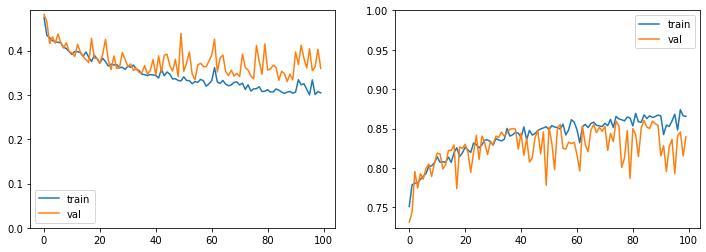

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6244 - accuracy: 0.5714 - precision: 0.9045 - recall: 0.5232 - f1: 0.6539 - specificity: 0.7794 - negative_predictive_value: 0.2866 - matthews_correlation_coefficient: 0.2378 - val_loss: 0.5783 - val_accuracy: 0.5811 - val_precision: 0.9063 - val_recall: 0.5006 - val_f1: 0.6387 - val_specificity: 0.8449 - val_negative_predictive_value: 0.3153 - val_matthews_correlation_coefficient: 0.2739

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27390, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_04_05-15_31_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6033 - accuracy: 0.5998 - precision: 0.9222 - recall: 0.5514 - f1: 0.6833 - specificity: 0.7876 - negative_predictive_value: 0.3062 - matthews_correlation_coefficient: 0.2771 - val_loss: 0.5474 - val_accuracy: 0.6210 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36980
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5537 - accuracy: 0.6659 - precision: 0.9324 - recall: 0.6299 - f1: 0.7458 - specificity: 0.8158 - negative_predictive_value: 0.3534 - matthews_correlation_coefficient: 0.3545 - val_loss: 0.5202 - val_accuracy: 0.7164 - val_precision: 0.8881 - val_recall: 0.6950 - val_f1: 0.7772 - val_specificity: 0.7395 - val_negative_predictive_value: 0.3994 - val_matthews_correlation_coefficient: 0.3508

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36980
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5520 - accuracy: 0.6614 - precision: 0.9292 - recall: 0.6323 - f1: 0.7423 - specificity: 0.7959 - negative_predictive_value: 0.3527 - matthews_correlation_coefficient: 0.3443 - val_loss: 0.5628 - val_accuracy: 0.6444 - val_precision: 0.9257 - val_recall: 0.5712 - val_f1: 0.7025 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5261 - accuracy: 0.6733 - precision: 0.9432 - recall: 0.6359 - f1: 0.7536 - specificity: 0.8367 - negative_predictive_value: 0.3628 - matthews_correlation_coefficient: 0.3782 - val_loss: 0.4774 - val_accuracy: 0.7138 - val_precision: 0.8685 - val_recall: 0.7088 - val_f1: 0.7782 - val_specificity: 0.6601 - val_negative_predictive_value: 0.3845 - val_matthews_correlation_coefficient: 0.3034

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39388
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5286 - accuracy: 0.6751 - precision: 0.9374 - recall: 0.6421 - f1: 0.7546 - specificity: 0.8226 - negative_predictive_value: 0.3658 - matthews_correlation_coefficient: 0.3707 - val_loss: 0.5801 - val_accuracy: 0.6756 - val_precision: 0.9267 - val_recall: 0.6086 - val_f1: 0.7305 - val_specificity: 0.8824 - val_negative_predictive_value: 0.3835 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5162 - accuracy: 0.6701 - precision: 0.9460 - recall: 0.6257 - f1: 0.7474 - specificity: 0.8362 - negative_predictive_value: 0.3609 - matthews_correlation_coefficient: 0.3767 - val_loss: 0.4675 - val_accuracy: 0.7129 - val_precision: 0.8692 - val_recall: 0.7079 - val_f1: 0.7779 - val_specificity: 0.6476 - val_negative_predictive_value: 0.3780 - val_matthews_correlation_coefficient: 0.2948

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39388
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5120 - accuracy: 0.6924 - precision: 0.9448 - recall: 0.6597 - f1: 0.7714 - specificity: 0.8332 - negative_predictive_value: 0.3832 - matthews_correlation_coefficient: 0.3983 - val_loss: 0.4704 - val_accuracy: 0.7216 - val_precision: 0.8879 - val_recall: 0.7009 - val_f1: 0.7812 - val_specificity: 0.7305 - val_negative_predictive_value: 0.4027 - val_matthews_correlation_coefficie

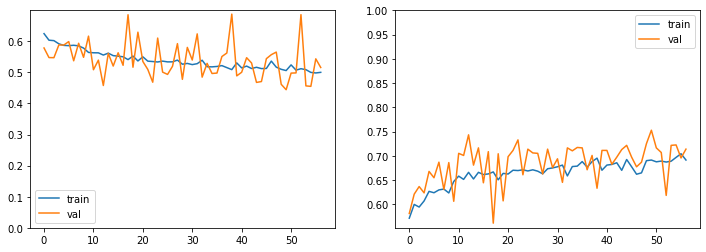

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5817 - accuracy: 0.5360 - precision: 0.9654 - recall: 0.5001 - f1: 0.6524 - specificity: 0.8647 - negative_predictive_value: 0.1813 - matthews_correlation_coefficient: 0.2281 - val_loss: 0.7151 - val_accuracy: 0.4692 - val_precision: 0.9443 - val_recall: 0.4046 - val_f1: 0.5611 - val_specificity: 0.8662 - val_negative_predictive_value: 0.1546 - val_matthews_correlation_coefficient: 0.1917

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.19168, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_04_05-15_39_44.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5610 - accuracy: 0.5629 - precision: 0.9680 - recall: 0.5274 - f1: 0.6747 - specificity: 0.8279 - negative_predictive_value: 0.1851 - matthews_correlation_coefficient: 0.2332 - val_loss: 0.5888 - val_accuracy: 0.5256 - val_pre

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4703 - accuracy: 0.7065 - precision: 0.9708 - recall: 0.6937 - f1: 0.8009 - specificity: 0.8253 - negative_predictive_value: 0.2695 - matthews_correlation_coefficient: 0.3440 - val_loss: 0.4855 - val_accuracy: 0.6999 - val_precision: 0.9443 - val_recall: 0.6641 - val_f1: 0.7773 - val_specificity: 0.8324 - val_negative_predictive_value: 0.2414 - val_matthews_correlation_coefficient: 0.3272

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32763
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4656 - accuracy: 0.7200 - precision: 0.9646 - recall: 0.7064 - f1: 0.8081 - specificity: 0.8214 - negative_predictive_value: 0.2779 - matthews_correlation_coefficient: 0.3564 - val_loss: 0.4930 - val_accuracy: 0.6834 - val_precision: 0.9414 - val_recall: 0.6467 - val_f1: 0.7637 - val_specificity: 0.8176 - val_negative_predictive_value: 0.2324 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4104 - accuracy: 0.7577 - precision: 0.9766 - recall: 0.7501 - f1: 0.8412 - specificity: 0.8235 - negative_predictive_value: 0.3166 - matthews_correlation_coefficient: 0.4007 - val_loss: 0.2784 - val_accuracy: 0.8760 - val_precision: 0.9313 - val_recall: 0.8768 - val_f1: 0.9025 - val_specificity: 0.6829 - val_negative_predictive_value: 0.4435 - val_matthews_correlation_coefficient: 0.4706

Epoch 00029: val_matthews_correlation_coefficient improved from 0.43389 to 0.47059, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_04_05-15_39_44.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3988 - accuracy: 0.7764 - precision: 0.9781 - recall: 0.7684 - f1: 0.8541 - specificity: 0.8417 - negative_predictive_value: 0.3438 - matthews_correlation_coefficient: 0.4324 - val_loss: 0.4118 - val_accuracy: 0.7580 - val_precision: 0.9503 - val_recall: 0.7246 - val_f1: 0.8202 - v


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.47059
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3868 - accuracy: 0.7829 - precision: 0.9777 - recall: 0.7759 - f1: 0.8584 - specificity: 0.8167 - negative_predictive_value: 0.3445 - matthews_correlation_coefficient: 0.4271 - val_loss: 0.4109 - val_accuracy: 0.7450 - val_precision: 0.9585 - val_recall: 0.7045 - val_f1: 0.8093 - val_specificity: 0.9059 - val_negative_predictive_value: 0.3128 - val_matthews_correlation_coefficient: 0.3986

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.47059
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3751 - accuracy: 0.7924 - precision: 0.9796 - recall: 0.7821 - f1: 0.8647 - specificity: 0.8680 - negative_predictive_value: 0.3562 - matthews_correlation_coefficient: 0.4575 - val_loss: 0.6796 - val_accuracy: 0.6323 - val_precision: 0.9679 - val_recall: 0.5720 - val_f1: 0.7142 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.53421
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4016 - accuracy: 0.7727 - precision: 0.9820 - recall: 0.7617 - f1: 0.8493 - specificity: 0.8675 - negative_predictive_value: 0.3447 - matthews_correlation_coefficient: 0.4441 - val_loss: 0.5403 - val_accuracy: 0.6774 - val_precision: 0.9672 - val_recall: 0.6217 - val_f1: 0.7531 - val_specificity: 0.9511 - val_negative_predictive_value: 0.2640 - val_matthews_correlation_coefficient: 0.3568

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.53421
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3749 - accuracy: 0.7911 - precision: 0.9806 - recall: 0.7846 - f1: 0.8665 - specificity: 0.8702 - negative_predictive_value: 0.3622 - matthews_correlation_coefficient: 0.4611 - val_loss: 0.6660 - val_accuracy: 0.6080 - val_precision: 0.9712 - val_recall: 0.5438 - val_f1: 0.6917 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.53421
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3420 - accuracy: 0.8076 - precision: 0.9820 - recall: 0.7982 - f1: 0.8758 - specificity: 0.8627 - negative_predictive_value: 0.3836 - matthews_correlation_coefficient: 0.4819 - val_loss: 0.6743 - val_accuracy: 0.6045 - val_precision: 0.9730 - val_recall: 0.5390 - val_f1: 0.6893 - val_specificity: 0.9730 - val_negative_predictive_value: 0.2356 - val_matthews_correlation_coefficient: 0.3205

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.53421
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3283 - accuracy: 0.8174 - precision: 0.9831 - recall: 0.8112 - f1: 0.8849 - specificity: 0.8816 - negative_predictive_value: 0.3899 - matthews_correlation_coefficient: 0.4982 - val_loss: 0.4603 - val_accuracy: 0.7320 - val_precision: 0.9664 - val_recall: 0.6835 - val_f1: 0.7978 - val_spe

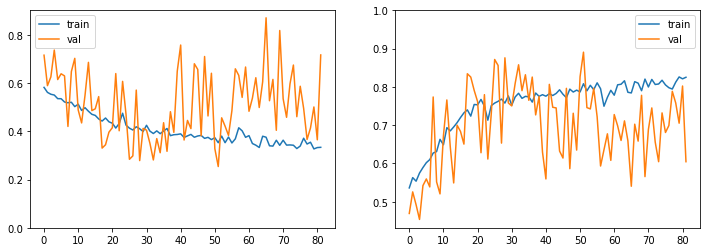

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5746 - accuracy: 0.6584 - precision: 0.9104 - recall: 0.6410 - f1: 0.7448 - specificity: 0.7402 - negative_predictive_value: 0.3429 - matthews_correlation_coefficient: 0.3078 - val_loss: 0.5199 - val_accuracy: 0.7467 - val_precision: 0.8773 - val_recall: 0.8030 - val_f1: 0.8352 - val_specificity: 0.5266 - val_negative_predictive_value: 0.3992 - val_matthews_correlation_coefficient: 0.3029

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30287, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_04_05-15_52_02.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5684 - accuracy: 0.6792 - precision: 0.9134 - recall: 0.6626 - f1: 0.7584 - specificity: 0.7457 - negative_predictive_value: 0.3720 - matthews_correlation_coefficient: 0.3374 - val_loss: 0.7039 - val_accuracy: 0.5429 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5229 - accuracy: 0.7106 - precision: 0.9190 - recall: 0.7035 - f1: 0.7926 - specificity: 0.7437 - negative_predictive_value: 0.3897 - matthews_correlation_coefficient: 0.3677 - val_loss: 0.5627 - val_accuracy: 0.7112 - val_precision: 0.9039 - val_recall: 0.7270 - val_f1: 0.8008 - val_specificity: 0.6635 - val_negative_predictive_value: 0.3808 - val_matthews_correlation_coefficient: 0.3320

Epoch 00015: val_matthews_correlation_coefficient improved from 0.32701 to 0.33200, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_04_05-15_52_02.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5173 - accuracy: 0.7226 - precision: 0.9198 - recall: 0.7154 - f1: 0.7989 - specificity: 0.7657 - negative_predictive_value: 0.4096 - matthews_correlation_coefficient: 0.3967 - val_loss: 0.6145 - val_accuracy: 0.6592 - val_precision: 0.9108 - val_recall: 0.6501 - val_f1: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4906 - accuracy: 0.7432 - precision: 0.9268 - recall: 0.7371 - f1: 0.8150 - specificity: 0.7450 - negative_predictive_value: 0.4291 - matthews_correlation_coefficient: 0.4114 - val_loss: 0.4779 - val_accuracy: 0.7407 - val_precision: 0.8990 - val_recall: 0.7709 - val_f1: 0.8262 - val_specificity: 0.6262 - val_negative_predictive_value: 0.4081 - val_matthews_correlation_coefficient: 0.3471

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41479
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4965 - accuracy: 0.7323 - precision: 0.9263 - recall: 0.7244 - f1: 0.8057 - specificity: 0.7463 - negative_predictive_value: 0.4187 - matthews_correlation_coefficient: 0.4005 - val_loss: 0.5658 - val_accuracy: 0.6635 - val_precision: 0.9366 - val_recall: 0.6342 - val_f1: 0.7492 - val_specificity: 0.7938 - val_negative_predictive_value: 0.3572 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4789 - accuracy: 0.7423 - precision: 0.9277 - recall: 0.7365 - f1: 0.8143 - specificity: 0.7676 - negative_predictive_value: 0.4369 - matthews_correlation_coefficient: 0.4265 - val_loss: 0.6476 - val_accuracy: 0.6167 - val_precision: 0.9574 - val_recall: 0.5592 - val_f1: 0.6973 - val_specificity: 0.8676 - val_negative_predictive_value: 0.3335 - val_matthews_correlation_coefficient: 0.3508

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.41479
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4760 - accuracy: 0.7453 - precision: 0.9317 - recall: 0.7377 - f1: 0.8160 - specificity: 0.7689 - negative_predictive_value: 0.4418 - matthews_correlation_coefficient: 0.4325 - val_loss: 0.6957 - val_accuracy: 0.6375 - val_precision: 0.9559 - val_recall: 0.5869 - val_f1: 0.7186 - val_specificity: 0.8643 - val_negative_predictive_value: 0.3472 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient improved from 0.41787 to 0.43022, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_04_05-15_52_02.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4580 - accuracy: 0.7560 - precision: 0.9375 - recall: 0.7486 - f1: 0.8252 - specificity: 0.7845 - negative_predictive_value: 0.4668 - matthews_correlation_coefficient: 0.4595 - val_loss: 0.6230 - val_accuracy: 0.6305 - val_precision: 0.9521 - val_recall: 0.5810 - val_f1: 0.7117 - val_specificity: 0.8511 - val_negative_predictive_value: 0.3432 - val_matthews_correlation_coefficient: 0.3558

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.43022
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4663 - accuracy: 0.7512 - precision: 0.9277 - recall: 0.7404 - f1: 0.8163 - specificity: 0.7801 - negative_predictive_value: 0.4581 - matthews_correlation_coefficient: 0.4471 - val_


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.43022
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4444 - accuracy: 0.7783 - precision: 0.9372 - recall: 0.7721 - f1: 0.8418 - specificity: 0.7902 - negative_predictive_value: 0.4698 - matthews_correlation_coefficient: 0.4756 - val_loss: 0.5713 - val_accuracy: 0.6661 - val_precision: 0.9460 - val_recall: 0.6311 - val_f1: 0.7502 - val_specificity: 0.8266 - val_negative_predictive_value: 0.3625 - val_matthews_correlation_coefficient: 0.3740

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.43022
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4401 - accuracy: 0.7690 - precision: 0.9379 - recall: 0.7647 - f1: 0.8355 - specificity: 0.7909 - negative_predictive_value: 0.4873 - matthews_correlation_coefficient: 0.4814 - val_loss: 0.5815 - val_accuracy: 0.6678 - val_precision: 0.9473 - val_recall: 0.6319 - val_f1: 0.7516 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4589 - accuracy: 0.7588 - precision: 0.9379 - recall: 0.7462 - f1: 0.8258 - specificity: 0.7796 - negative_predictive_value: 0.4541 - matthews_correlation_coefficient: 0.4533 - val_loss: 0.5738 - val_accuracy: 0.6331 - val_precision: 0.9584 - val_recall: 0.5786 - val_f1: 0.7144 - val_specificity: 0.8726 - val_negative_predictive_value: 0.3440 - val_matthews_correlation_coefficient: 0.3677

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.44531
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4422 - accuracy: 0.7607 - precision: 0.9373 - recall: 0.7420 - f1: 0.8219 - specificity: 0.8252 - negative_predictive_value: 0.4675 - matthews_correlation_coefficient: 0.4796 - val_loss: 0.4890 - val_accuracy: 0.7199 - val_precision: 0.9435 - val_recall: 0.7022 - val_f1: 0.8004 - val_specificity: 0.7979 - val_negative_predictive_value: 0.4023 - val_matthews_correlation_coefficie

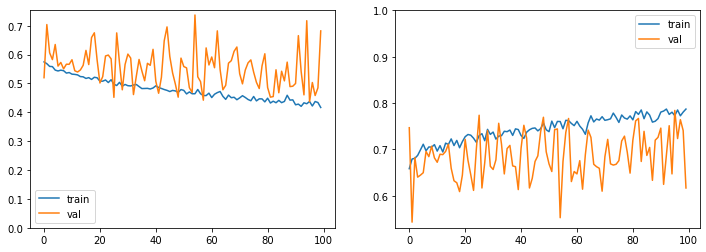

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6293 - accuracy: 0.8100 - precision: 0.9981 - recall: 0.8123 - f1: 0.8815 - specificity: 0.0414 - negative_predictive_value: 0.0036 - matthews_correlation_coefficient: 0.0080 - val_loss: 0.1550 - val_accuracy: 0.9870 - val_precision: 0.9983 - val_recall: 0.9890 - val_f1: 0.9935 - val_specificity: 0.0270 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0253

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.02528, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_04_05-16_07_51.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5696 - accuracy: 0.7510 - precision: 0.9984 - recall: 0.7536 - f1: 0.8448 - specificity: 0.0483 - negative_predictive_value: 0.0061 - matthews_correlation_coefficient: 0.0133 - val_loss: 0.1638 - val_accuracy: 0.9324 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2981 - accuracy: 0.8432 - precision: 0.9996 - recall: 0.8440 - f1: 0.9083 - specificity: 0.0690 - negative_predictive_value: 0.0137 - matthews_correlation_coefficient: 0.0256 - val_loss: 0.3009 - val_accuracy: 0.8187 - val_precision: 1.0000 - val_recall: 0.8233 - val_f1: 0.9016 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0225 - val_matthews_correlation_coefficient: 0.0408

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.05405
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3849 - accuracy: 0.8538 - precision: 0.9996 - recall: 0.8548 - f1: 0.9161 - specificity: 0.0828 - negative_predictive_value: 0.0221 - matthews_correlation_coefficient: 0.0378 - val_loss: 0.4909 - val_accuracy: 0.7329 - val_precision: 1.0000 - val_recall: 0.7392 - val_f1: 0.8483 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0097 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.07285
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1566 - accuracy: 0.9048 - precision: 1.0000 - recall: 0.9052 - f1: 0.9478 - specificity: 0.0897 - negative_predictive_value: 0.0382 - matthews_correlation_coefficient: 0.0552 - val_loss: 0.1382 - val_accuracy: 0.9488 - val_precision: 1.0000 - val_recall: 0.9501 - val_f1: 0.9740 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0495 - val_matthews_correlation_coefficient: 0.0609

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.07285
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2112 - accuracy: 0.8846 - precision: 0.9998 - recall: 0.8852 - f1: 0.9352 - specificity: 0.0828 - negative_predictive_value: 0.0380 - matthews_correlation_coefficient: 0.0501 - val_loss: 0.0326 - val_accuracy: 0.9957 - val_precision: 1.0000 - val_recall: 0.9958 - val_f1: 0.9979 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0453 - accuracy: 0.9779 - precision: 1.0000 - recall: 0.9780 - f1: 0.9886 - specificity: 0.0966 - negative_predictive_value: 0.0764 - matthews_correlation_coefficient: 0.0836 - val_loss: 0.0124 - val_accuracy: 0.9957 - val_precision: 0.9992 - val_recall: 0.9966 - val_f1: 0.9979 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0541 - val_matthews_correlation_coefficient: 0.0541

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1311 - accuracy: 0.9479 - precision: 0.9998 - recall: 0.9484 - f1: 0.9701 - specificity: 0.0828 - negative_predictive_value: 0.0592 - matthews_correlation_coefficient: 0.0660 - val_loss: 0.7489 - val_accuracy: 0.7181 - val_precision: 1.0000 - val_recall: 0.7249 - val_f1: 0.8378 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0436 - accuracy: 0.9848 - precision: 1.0000 - recall: 0.9849 - f1: 0.9922 - specificity: 0.0966 - negative_predictive_value: 0.0931 - matthews_correlation_coefficient: 0.0945 - val_loss: 0.0345 - val_accuracy: 0.9905 - val_precision: 1.0000 - val_recall: 0.9907 - val_f1: 0.9953 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0811 - val_matthews_correlation_coefficient: 0.0811

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2968 - accuracy: 0.9152 - precision: 0.9998 - recall: 0.9126 - f1: 0.9492 - specificity: 0.0897 - negative_predictive_value: 0.0646 - matthews_correlation_coefficient: 0.0713 - val_loss: 0.8948 - val_accuracy: 0.6895 - val_precision: 1.0000 - val_recall: 0.6968 - val_f1: 0.8182 - val_spe

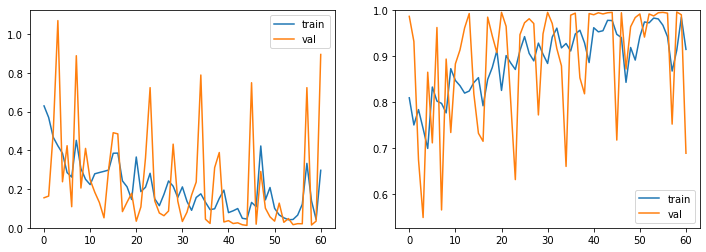

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6024 - accuracy: 0.6280 - precision: 0.8711 - recall: 0.5551 - f1: 0.6662 - specificity: 0.7989 - negative_predictive_value: 0.4296 - matthews_correlation_coefficient: 0.3240 - val_loss: 0.6589 - val_accuracy: 0.5499 - val_precision: 0.8899 - val_recall: 0.3902 - val_f1: 0.5348 - val_specificity: 0.8892 - val_negative_predictive_value: 0.3752 - val_matthews_correlation_coefficient: 0.2967

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29665, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_04_05-16_17_10.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5935 - accuracy: 0.6239 - precision: 0.8881 - recall: 0.5536 - f1: 0.6673 - specificity: 0.8030 - negative_predictive_value: 0.4235 - matthews_correlation_coefficient: 0.3314 - val_loss: 0.5311 - val_accuracy: 0.6956 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5437 - accuracy: 0.6896 - precision: 0.9016 - recall: 0.6288 - f1: 0.7338 - specificity: 0.8341 - negative_predictive_value: 0.4797 - matthews_correlation_coefficient: 0.4182 - val_loss: 0.6229 - val_accuracy: 0.6574 - val_precision: 0.9030 - val_recall: 0.5439 - val_f1: 0.6724 - val_specificity: 0.8638 - val_negative_predictive_value: 0.4406 - val_matthews_correlation_coefficient: 0.3992

Epoch 00015: val_matthews_correlation_coefficient improved from 0.38493 to 0.39915, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_04_05-16_17_10.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5482 - accuracy: 0.6831 - precision: 0.8930 - recall: 0.6240 - f1: 0.7277 - specificity: 0.8226 - negative_predictive_value: 0.4745 - matthews_correlation_coefficient: 0.4099 - val_loss: 0.5591 - val_accuracy: 0.6973 - val_precision: 0.8830 - val_recall: 0.6185 - val_f1: 0.7222 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5159 - accuracy: 0.7113 - precision: 0.9174 - recall: 0.6560 - f1: 0.7577 - specificity: 0.8478 - negative_predictive_value: 0.4994 - matthews_correlation_coefficient: 0.4559 - val_loss: 0.4913 - val_accuracy: 0.7268 - val_precision: 0.8323 - val_recall: 0.7135 - val_f1: 0.7647 - val_specificity: 0.6932 - val_negative_predictive_value: 0.5145 - val_matthews_correlation_coefficient: 0.4009

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42235
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5068 - accuracy: 0.7178 - precision: 0.9191 - recall: 0.6642 - f1: 0.7653 - specificity: 0.8507 - negative_predictive_value: 0.5084 - matthews_correlation_coefficient: 0.4688 - val_loss: 0.5382 - val_accuracy: 0.6921 - val_precision: 0.8683 - val_recall: 0.6259 - val_f1: 0.7210 - val_specificity: 0.7905 - val_negative_predictive_value: 0.4719 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45284
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5016 - accuracy: 0.7223 - precision: 0.9205 - recall: 0.6689 - f1: 0.7678 - specificity: 0.8548 - negative_predictive_value: 0.5188 - matthews_correlation_coefficient: 0.4780 - val_loss: 0.5372 - val_accuracy: 0.6904 - val_precision: 0.8899 - val_recall: 0.6041 - val_f1: 0.7138 - val_specificity: 0.8303 - val_negative_predictive_value: 0.4685 - val_matthews_correlation_coefficient: 0.4198

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45284
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4986 - accuracy: 0.7191 - precision: 0.9207 - recall: 0.6610 - f1: 0.7646 - specificity: 0.8581 - negative_predictive_value: 0.5097 - matthews_correlation_coefficient: 0.4724 - val_loss: 0.5038 - val_accuracy: 0.7311 - val_precision: 0.8664 - val_recall: 0.6879 - val_f1: 0.7613 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45284
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4762 - accuracy: 0.7362 - precision: 0.9253 - recall: 0.6814 - f1: 0.7810 - specificity: 0.8611 - negative_predictive_value: 0.5235 - matthews_correlation_coefficient: 0.4927 - val_loss: 0.5106 - val_accuracy: 0.7199 - val_precision: 0.8863 - val_recall: 0.6494 - val_f1: 0.7447 - val_specificity: 0.8168 - val_negative_predictive_value: 0.4976 - val_matthews_correlation_coefficient: 0.4483

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45284
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4705 - accuracy: 0.7432 - precision: 0.9248 - recall: 0.6989 - f1: 0.7912 - specificity: 0.8556 - negative_predictive_value: 0.5349 - matthews_correlation_coefficient: 0.5022 - val_loss: 0.5376 - val_accuracy: 0.7138 - val_precision: 0.8859 - val_recall: 0.6422 - val_f1: 0.7380 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4713 - accuracy: 0.7462 - precision: 0.9285 - recall: 0.6969 - f1: 0.7912 - specificity: 0.8635 - negative_predictive_value: 0.5393 - matthews_correlation_coefficient: 0.5101 - val_loss: 0.5186 - val_accuracy: 0.7225 - val_precision: 0.8900 - val_recall: 0.6548 - val_f1: 0.7493 - val_specificity: 0.8166 - val_negative_predictive_value: 0.5002 - val_matthews_correlation_coefficient: 0.4539

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46562
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4694 - accuracy: 0.7401 - precision: 0.9259 - recall: 0.6944 - f1: 0.7882 - specificity: 0.8579 - negative_predictive_value: 0.5369 - matthews_correlation_coefficient: 0.5037 - val_loss: 0.5393 - val_accuracy: 0.6990 - val_precision: 0.8946 - val_recall: 0.6149 - val_f1: 0.7236 - val_specificity: 0.8361 - val_negative_predictive_value: 0.4762 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.48131
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4811 - accuracy: 0.7412 - precision: 0.9181 - recall: 0.7020 - f1: 0.7906 - specificity: 0.8524 - negative_predictive_value: 0.5403 - matthews_correlation_coefficient: 0.5018 - val_loss: 0.5637 - val_accuracy: 0.6947 - val_precision: 0.8943 - val_recall: 0.6075 - val_f1: 0.7178 - val_specificity: 0.8410 - val_negative_predictive_value: 0.4742 - val_matthews_correlation_coefficient: 0.4318

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.48131
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4774 - accuracy: 0.7390 - precision: 0.9203 - recall: 0.6926 - f1: 0.7852 - specificity: 0.8538 - negative_predictive_value: 0.5307 - matthews_correlation_coefficient: 0.4961 - val_loss: 0.6042 - val_accuracy: 0.6696 - val_precision: 0.8960 - val_recall: 0.5709 - val_f1: 0.6899 - val_spe

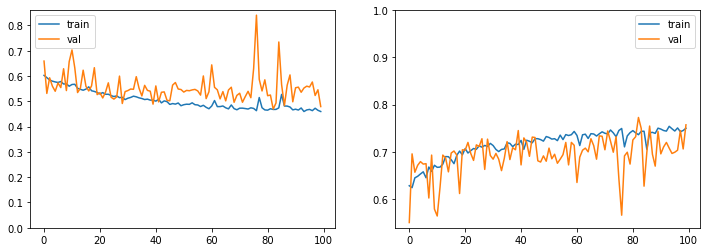

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5981 - accuracy: 0.5933 - precision: 0.9314 - recall: 0.5713 - f1: 0.6960 - specificity: 0.7422 - negative_predictive_value: 0.2314 - matthews_correlation_coefficient: 0.2216 - val_loss: 0.5412 - val_accuracy: 0.6357 - val_precision: 0.9053 - val_recall: 0.6024 - val_f1: 0.7202 - val_specificity: 0.7361 - val_negative_predictive_value: 0.2473 - val_matthews_correlation_coefficient: 0.2501

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25012, saving model to ../models/autoencoders_requirements/hat_cap_2020_04_05-16_32_11.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5594 - accuracy: 0.6158 - precision: 0.9447 - recall: 0.5901 - f1: 0.7159 - specificity: 0.7877 - negative_predictive_value: 0.2516 - matthews_correlation_coefficient: 0.2675 - val_loss: 0.4843 - val_accuracy: 0.7034 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.38685
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4940 - accuracy: 0.6911 - precision: 0.9543 - recall: 0.6758 - f1: 0.7826 - specificity: 0.7834 - negative_predictive_value: 0.3030 - matthews_correlation_coefficient: 0.3399 - val_loss: 0.4382 - val_accuracy: 0.7598 - val_precision: 0.9517 - val_recall: 0.7651 - val_f1: 0.8451 - val_specificity: 0.7825 - val_negative_predictive_value: 0.3448 - val_matthews_correlation_coefficient: 0.3947

Epoch 00015: val_matthews_correlation_coefficient improved from 0.38685 to 0.39474, saving model to ../models/autoencoders_requirements/hat_cap_2020_04_05-16_32_11.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4887 - accuracy: 0.7115 - precision: 0.9518 - recall: 0.6978 - f1: 0.7990 - specificity: 0.7933 - negative_predictive_value: 0.3173 - matthews_correlation_coefficient: 0.3575 - val_loss: 0.5167 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4542 - accuracy: 0.7323 - precision: 0.9555 - recall: 0.7116 - f1: 0.8115 - specificity: 0.8122 - negative_predictive_value: 0.3359 - matthews_correlation_coefficient: 0.3934 - val_loss: 0.5317 - val_accuracy: 0.6713 - val_precision: 0.9788 - val_recall: 0.6357 - val_f1: 0.7658 - val_specificity: 0.9141 - val_negative_predictive_value: 0.2920 - val_matthews_correlation_coefficient: 0.3790

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43288
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5099 - accuracy: 0.6859 - precision: 0.9572 - recall: 0.6692 - f1: 0.7733 - specificity: 0.8060 - negative_predictive_value: 0.3153 - matthews_correlation_coefficient: 0.3533 - val_loss: 0.4678 - val_accuracy: 0.7398 - val_precision: 0.9619 - val_recall: 0.7321 - val_f1: 0.8272 - val_specificity: 0.8258 - val_negative_predictive_value: 0.3383 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4242 - accuracy: 0.7510 - precision: 0.9630 - recall: 0.7394 - f1: 0.8316 - specificity: 0.8115 - negative_predictive_value: 0.3562 - matthews_correlation_coefficient: 0.4151 - val_loss: 0.4031 - val_accuracy: 0.7702 - val_precision: 0.9615 - val_recall: 0.7699 - val_f1: 0.8518 - val_specificity: 0.8233 - val_negative_predictive_value: 0.3654 - val_matthews_correlation_coefficient: 0.4315

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43288
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4429 - accuracy: 0.7321 - precision: 0.9617 - recall: 0.7187 - f1: 0.8151 - specificity: 0.8134 - negative_predictive_value: 0.3454 - matthews_correlation_coefficient: 0.3972 - val_loss: 0.3750 - val_accuracy: 0.8153 - val_precision: 0.9330 - val_recall: 0.8501 - val_f1: 0.8880 - val_specificity: 0.6086 - val_negative_predictive_value: 0.3902 - val_matthews_correlation_coefficie

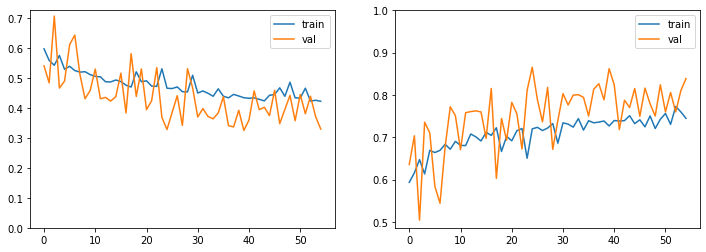

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4110 - accuracy: 0.7679 - precision: 0.9930 - recall: 0.7597 - f1: 0.8534 - specificity: 0.8003 - negative_predictive_value: 0.2149 - matthews_correlation_coefficient: 0.3415 - val_loss: 0.3422 - val_accuracy: 0.8560 - val_precision: 0.9623 - val_recall: 0.8337 - val_f1: 0.8923 - val_specificity: 0.7477 - val_negative_predictive_value: 0.2705 - val_matthews_correlation_coefficient: 0.3886

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38865, saving model to ../models/autoencoders_requirements/veil_over_face_2020_04_05-16_40_31.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3098 - accuracy: 0.8692 - precision: 0.9926 - recall: 0.8654 - f1: 0.9221 - specificity: 0.7458 - negative_predictive_value: 0.3197 - matthews_correlation_coefficient: 0.4318 - val_loss: 0.4093 - val_accuracy: 0.8335 - val_precis

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2483 - accuracy: 0.9121 - precision: 0.9925 - recall: 0.9140 - f1: 0.9506 - specificity: 0.7916 - negative_predictive_value: 0.4298 - matthews_correlation_coefficient: 0.5345 - val_loss: 0.3891 - val_accuracy: 0.8768 - val_precision: 0.9624 - val_recall: 0.8551 - val_f1: 0.9049 - val_specificity: 0.7477 - val_negative_predictive_value: 0.3013 - val_matthews_correlation_coefficient: 0.4197

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.52151
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2368 - accuracy: 0.9115 - precision: 0.9926 - recall: 0.9098 - f1: 0.9479 - specificity: 0.7953 - negative_predictive_value: 0.4127 - matthews_correlation_coefficient: 0.5240 - val_loss: 0.2031 - val_accuracy: 0.9384 - val_precision: 0.9615 - val_recall: 0.9209 - val_f1: 0.9403 - val_specificity: 0.7252 - val_negative_predictive_value: 0.4672 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1957 - accuracy: 0.9304 - precision: 0.9937 - recall: 0.9326 - f1: 0.9613 - specificity: 0.7568 - negative_predictive_value: 0.4630 - matthews_correlation_coefficient: 0.5512 - val_loss: 0.1810 - val_accuracy: 0.9436 - val_precision: 0.9885 - val_recall: 0.9522 - val_f1: 0.9696 - val_specificity: 0.7252 - val_negative_predictive_value: 0.5157 - val_matthews_correlation_coefficient: 0.5749

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.59560
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1936 - accuracy: 0.9269 - precision: 0.9900 - recall: 0.9291 - f1: 0.9568 - specificity: 0.8038 - negative_predictive_value: 0.4911 - matthews_correlation_coefficient: 0.5852 - val_loss: 0.3405 - val_accuracy: 0.9037 - val_precision: 0.9640 - val_recall: 0.8823 - val_f1: 0.9207 - val_specificity: 0.7568 - val_negative_predictive_value: 0.3616 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.65586
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1978 - accuracy: 0.9321 - precision: 0.9944 - recall: 0.9334 - f1: 0.9619 - specificity: 0.7831 - negative_predictive_value: 0.5121 - matthews_correlation_coefficient: 0.5888 - val_loss: 0.1535 - val_accuracy: 0.9488 - val_precision: 0.9636 - val_recall: 0.9298 - val_f1: 0.9461 - val_specificity: 0.7477 - val_negative_predictive_value: 0.5053 - val_matthews_correlation_coefficient: 0.5805

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.65586
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1799 - accuracy: 0.9401 - precision: 0.9937 - recall: 0.9396 - f1: 0.9647 - specificity: 0.8140 - negative_predictive_value: 0.5322 - matthews_correlation_coefficient: 0.6189 - val_loss: 0.4159 - val_accuracy: 0.8265 - val_precision: 0.9666 - val_recall: 0.7998 - val_f1: 0.8740 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1456 - accuracy: 0.9499 - precision: 0.9949 - recall: 0.9487 - f1: 0.9702 - specificity: 0.7903 - negative_predictive_value: 0.5613 - matthews_correlation_coefficient: 0.6351 - val_loss: 0.2958 - val_accuracy: 0.9046 - val_precision: 0.9650 - val_recall: 0.8824 - val_f1: 0.9214 - val_specificity: 0.7658 - val_negative_predictive_value: 0.3539 - val_matthews_correlation_coefficient: 0.4738

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.69101
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1606 - accuracy: 0.9544 - precision: 0.9946 - recall: 0.9538 - f1: 0.9726 - specificity: 0.8397 - negative_predictive_value: 0.6366 - matthews_correlation_coefficient: 0.6913 - val_loss: 0.4423 - val_accuracy: 0.8448 - val_precision: 0.9663 - val_recall: 0.8180 - val_f1: 0.8855 - val_specificity: 0.7995 - val_negative_predictive_value: 0.2559 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1487 - accuracy: 0.9475 - precision: 0.9950 - recall: 0.9494 - f1: 0.9707 - specificity: 0.8103 - negative_predictive_value: 0.5559 - matthews_correlation_coefficient: 0.6355 - val_loss: 0.2402 - val_accuracy: 0.9107 - val_precision: 0.9681 - val_recall: 0.8857 - val_f1: 0.9246 - val_specificity: 0.8086 - val_negative_predictive_value: 0.3923 - val_matthews_correlation_coefficient: 0.5180

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.69101
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1373 - accuracy: 0.9540 - precision: 0.9955 - recall: 0.9559 - f1: 0.9747 - specificity: 0.8302 - negative_predictive_value: 0.5819 - matthews_correlation_coefficient: 0.6596 - val_loss: 0.2734 - val_accuracy: 0.8942 - val_precision: 0.9678 - val_recall: 0.8685 - val_f1: 0.9149 - val_specificity: 0.8086 - val_negative_predictive_value: 0.3456 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.70268
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1311 - accuracy: 0.9523 - precision: 0.9961 - recall: 0.9533 - f1: 0.9736 - specificity: 0.8437 - negative_predictive_value: 0.5846 - matthews_correlation_coefficient: 0.6693 - val_loss: 0.2288 - val_accuracy: 0.9124 - val_precision: 0.9680 - val_recall: 0.8875 - val_f1: 0.9255 - val_specificity: 0.8086 - val_negative_predictive_value: 0.3957 - val_matthews_correlation_coefficient: 0.5236

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.70268
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1220 - accuracy: 0.9540 - precision: 0.9954 - recall: 0.9529 - f1: 0.9725 - specificity: 0.7834 - negative_predictive_value: 0.5862 - matthews_correlation_coefficient: 0.6474 - val_loss: 0.4386 - val_accuracy: 0.8491 - val_precision: 0.9676 - val_recall: 0.8216 - val_f1: 0.8879 - val_spe

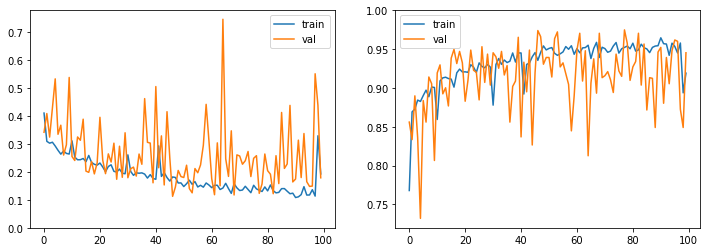

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6067 - accuracy: 0.6518 - precision: 0.8783 - recall: 0.6234 - f1: 0.7177 - specificity: 0.7493 - negative_predictive_value: 0.4118 - matthews_correlation_coefficient: 0.3305 - val_loss: 0.6378 - val_accuracy: 0.6123 - val_precision: 0.8515 - val_recall: 0.5341 - val_f1: 0.6495 - val_specificity: 0.7958 - val_negative_predictive_value: 0.4068 - val_matthews_correlation_coefficient: 0.2906

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29059, saving model to ../models/autoencoders_requirements/mouth_open_2020_04_05-16_55_29.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5807 - accuracy: 0.6679 - precision: 0.8845 - recall: 0.6353 - f1: 0.7295 - specificity: 0.7649 - negative_predictive_value: 0.4342 - matthews_correlation_coefficient: 0.3567 - val_loss: 0.6701 - val_accuracy: 0.6071 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.37281
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5442 - accuracy: 0.6961 - precision: 0.8866 - recall: 0.6635 - f1: 0.7536 - specificity: 0.7772 - negative_predictive_value: 0.4595 - matthews_correlation_coefficient: 0.3903 - val_loss: 0.6479 - val_accuracy: 0.6583 - val_precision: 0.8639 - val_recall: 0.5941 - val_f1: 0.6994 - val_specificity: 0.7985 - val_negative_predictive_value: 0.4394 - val_matthews_correlation_coefficient: 0.3434

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37281
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5450 - accuracy: 0.6967 - precision: 0.8912 - recall: 0.6680 - f1: 0.7588 - specificity: 0.7743 - negative_predictive_value: 0.4580 - matthews_correlation_coefficient: 0.3927 - val_loss: 0.5965 - val_accuracy: 0.6808 - val_precision: 0.8495 - val_recall: 0.6418 - val_f1: 0.7271 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38598
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5285 - accuracy: 0.7156 - precision: 0.9046 - recall: 0.6867 - f1: 0.7748 - specificity: 0.7893 - negative_predictive_value: 0.4803 - matthews_correlation_coefficient: 0.4278 - val_loss: 0.5813 - val_accuracy: 0.6886 - val_precision: 0.8477 - val_recall: 0.6565 - val_f1: 0.7361 - val_specificity: 0.7426 - val_negative_predictive_value: 0.4630 - val_matthews_correlation_coefficient: 0.3505

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38598
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5367 - accuracy: 0.7087 - precision: 0.8936 - recall: 0.6758 - f1: 0.7640 - specificity: 0.7840 - negative_predictive_value: 0.4746 - matthews_correlation_coefficient: 0.4118 - val_loss: 0.5772 - val_accuracy: 0.6739 - val_precision: 0.8574 - val_recall: 0.6229 - val_f1: 0.7172 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.38827 to 0.39000, saving model to ../models/autoencoders_requirements/mouth_open_2020_04_05-16_55_29.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5181 - accuracy: 0.7124 - precision: 0.9016 - recall: 0.6837 - f1: 0.7715 - specificity: 0.7857 - negative_predictive_value: 0.4755 - matthews_correlation_coefficient: 0.4199 - val_loss: 0.5027 - val_accuracy: 0.7225 - val_precision: 0.8401 - val_recall: 0.7206 - val_f1: 0.7723 - val_specificity: 0.6966 - val_negative_predictive_value: 0.5031 - val_matthews_correlation_coefficient: 0.3765

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.39000
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5160 - accuracy: 0.7271 - precision: 0.8896 - recall: 0.7096 - f1: 0.7842 - specificity: 0.7679 - negative_predictive_value: 0.4947 - matthews_correlation_coefficient: 0.4262 - val_loss: 0.6297 - v


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39000
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5090 - accuracy: 0.7126 - precision: 0.9031 - recall: 0.6817 - f1: 0.7722 - specificity: 0.7907 - negative_predictive_value: 0.4722 - matthews_correlation_coefficient: 0.4205 - val_loss: 0.5641 - val_accuracy: 0.6904 - val_precision: 0.8691 - val_recall: 0.6378 - val_f1: 0.7324 - val_specificity: 0.7976 - val_negative_predictive_value: 0.4659 - val_matthews_correlation_coefficient: 0.3802

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.39000
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5073 - accuracy: 0.7262 - precision: 0.9029 - recall: 0.7024 - f1: 0.7850 - specificity: 0.7847 - negative_predictive_value: 0.4933 - matthews_correlation_coefficient: 0.4386 - val_loss: 0.5113 - val_accuracy: 0.7095 - val_precision: 0.8373 - val_recall: 0.7011 - val_f1: 0.7596 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.41269
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4942 - accuracy: 0.7262 - precision: 0.9049 - recall: 0.6940 - f1: 0.7802 - specificity: 0.8035 - negative_predictive_value: 0.4905 - matthews_correlation_coefficient: 0.4480 - val_loss: 0.5491 - val_accuracy: 0.7069 - val_precision: 0.8440 - val_recall: 0.6894 - val_f1: 0.7545 - val_specificity: 0.7094 - val_negative_predictive_value: 0.4851 - val_matthews_correlation_coefficient: 0.3609

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.41269
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4966 - accuracy: 0.7302 - precision: 0.9102 - recall: 0.7077 - f1: 0.7900 - specificity: 0.8016 - negative_predictive_value: 0.5036 - matthews_correlation_coefficient: 0.4571 - val_loss: 0.5201 - val_accuracy: 0.7069 - val_precision: 0.8612 - val_recall: 0.6723 - val_f1: 0.7512 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4872 - accuracy: 0.7395 - precision: 0.9079 - recall: 0.7208 - f1: 0.7989 - specificity: 0.7983 - negative_predictive_value: 0.5136 - matthews_correlation_coefficient: 0.4658 - val_loss: 0.6907 - val_accuracy: 0.6262 - val_precision: 0.9058 - val_recall: 0.5127 - val_f1: 0.6484 - val_specificity: 0.9031 - val_negative_predictive_value: 0.4260 - val_matthews_correlation_coefficient: 0.3694

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.41705
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4888 - accuracy: 0.7345 - precision: 0.9121 - recall: 0.7105 - f1: 0.7929 - specificity: 0.8097 - negative_predictive_value: 0.5096 - matthews_correlation_coefficient: 0.4659 - val_loss: 0.6393 - val_accuracy: 0.6375 - val_precision: 0.9053 - val_recall: 0.5313 - val_f1: 0.6624 - val_specificity: 0.8955 - val_negative_predictive_value: 0.4333 - val_matthews_correlation_coefficie

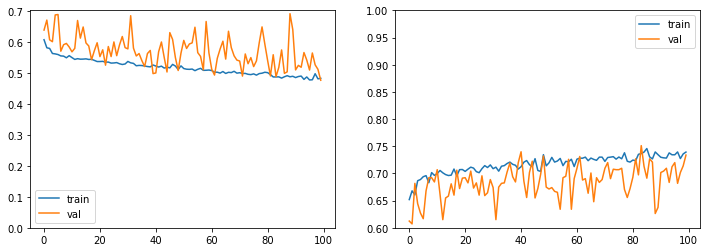

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4471 - accuracy: 0.7714 - precision: 0.9973 - recall: 0.7686 - f1: 0.8574 - specificity: 0.2862 - negative_predictive_value: 0.0579 - matthews_correlation_coefficient: 0.1032 - val_loss: 0.7151 - val_accuracy: 0.6938 - val_precision: 1.0000 - val_recall: 0.6984 - val_f1: 0.8180 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0410 - val_matthews_correlation_coefficient: 0.0897

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.08974, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_04_05-17_10_29.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3720 - accuracy: 0.8228 - precision: 0.9979 - recall: 0.8234 - f1: 0.9004 - specificity: 0.2747 - negative_predictive_value: 0.0526 - matthews_correlation_coefficient: 0.1026 - val_loss: 0.2559 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2732 - accuracy: 0.8456 - precision: 0.9993 - recall: 0.8455 - f1: 0.9146 - specificity: 0.2966 - negative_predictive_value: 0.0732 - matthews_correlation_coefficient: 0.1329 - val_loss: 0.3477 - val_accuracy: 0.8560 - val_precision: 1.0000 - val_recall: 0.8585 - val_f1: 0.9221 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0933 - val_matthews_correlation_coefficient: 0.1479

Epoch 00015: val_matthews_correlation_coefficient improved from 0.14257 to 0.14790, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_04_05-17_10_29.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2873 - accuracy: 0.8315 - precision: 0.9988 - recall: 0.8317 - f1: 0.9055 - specificity: 0.3069 - negative_predictive_value: 0.0683 - matthews_correlation_coefficient: 0.1270 - val_loss: 0.2877 - val_accuracy: 0.8465 - val_precision: 1.0000 - val_recall: 0.8489 - val_f


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.14908
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2579 - accuracy: 0.8458 - precision: 0.9995 - recall: 0.8452 - f1: 0.9145 - specificity: 0.3276 - negative_predictive_value: 0.0724 - matthews_correlation_coefficient: 0.1365 - val_loss: 0.3294 - val_accuracy: 0.8040 - val_precision: 1.0000 - val_recall: 0.8069 - val_f1: 0.8908 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0612 - val_matthews_correlation_coefficient: 0.1164

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.14908
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2646 - accuracy: 0.8219 - precision: 0.9994 - recall: 0.8214 - f1: 0.8998 - specificity: 0.3034 - negative_predictive_value: 0.0673 - matthews_correlation_coefficient: 0.1277 - val_loss: 0.2279 - val_accuracy: 0.8638 - val_precision: 0.9990 - val_recall: 0.8670 - val_f1: 0.9269 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.14908 to 0.15415, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_04_05-17_10_29.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2603 - accuracy: 0.8410 - precision: 0.9993 - recall: 0.8407 - f1: 0.9114 - specificity: 0.3276 - negative_predictive_value: 0.0698 - matthews_correlation_coefficient: 0.1342 - val_loss: 0.2927 - val_accuracy: 0.8413 - val_precision: 0.9979 - val_recall: 0.8456 - val_f1: 0.9138 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0705 - val_matthews_correlation_coefficient: 0.1135

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.15415
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2654 - accuracy: 0.8464 - precision: 0.9995 - recall: 0.8462 - f1: 0.9152 - specificity: 0.3218 - negative_predictive_value: 0.0826 - matthews_correlation_coefficient: 0.1460 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2161 - accuracy: 0.8592 - precision: 0.9998 - recall: 0.8588 - f1: 0.9227 - specificity: 0.3138 - negative_predictive_value: 0.0859 - matthews_correlation_coefficient: 0.1484 - val_loss: 0.2368 - val_accuracy: 0.8812 - val_precision: 1.0000 - val_recall: 0.8833 - val_f1: 0.9370 - val_specificity: 0.2973 - val_negative_predictive_value: 0.1020 - val_matthews_correlation_coefficient: 0.1610

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.18191
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2065 - accuracy: 0.8707 - precision: 0.9995 - recall: 0.8701 - f1: 0.9292 - specificity: 0.3103 - negative_predictive_value: 0.0724 - matthews_correlation_coefficient: 0.1341 - val_loss: 0.3278 - val_accuracy: 0.8612 - val_precision: 1.0000 - val_recall: 0.8637 - val_f1: 0.9255 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0926 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2295 - accuracy: 0.8653 - precision: 0.9993 - recall: 0.8620 - f1: 0.9239 - specificity: 0.2931 - negative_predictive_value: 0.0790 - matthews_correlation_coefficient: 0.1364 - val_loss: 0.3949 - val_accuracy: 0.8057 - val_precision: 1.0000 - val_recall: 0.8087 - val_f1: 0.8921 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0647 - val_matthews_correlation_coefficient: 0.1209

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.18191
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2175 - accuracy: 0.8486 - precision: 0.9998 - recall: 0.8478 - f1: 0.9165 - specificity: 0.3172 - negative_predictive_value: 0.0699 - matthews_correlation_coefficient: 0.1331 - val_loss: 0.2405 - val_accuracy: 0.8846 - val_precision: 1.0000 - val_recall: 0.8868 - val_f1: 0.9390 - val_specificity: 0.2973 - val_negative_predictive_value: 0.1138 - val_matthews_correlation_coefficie

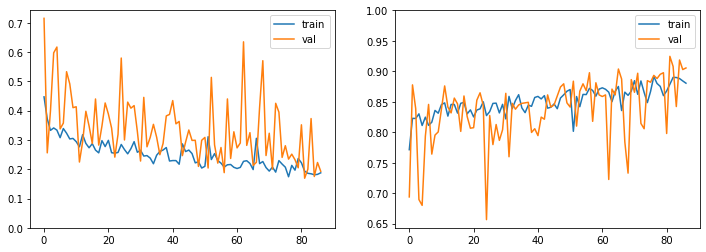

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_04_05-12_32_09.h5'
 '../models/autoencoders_requirements/looking_away_2020_04_05-12_44_24.h5'
 '../models/autoencoders_requirements/ink_marked_creased_2020_04_05-12_59_29.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_04_05-13_05_45.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_04_05-13_20_27.h5'
 '../models/autoencoders_requirements/washed_out_2020_04_05-13_35_12.h5'
 '../models/autoencoders_requirements/pixelation_2020_04_05-13_48_21.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_04_05-13_54_06.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_04_05-14_09_00.h5'
 '../models/autoencoders_requirements/varied_background_2020_04_05-14_23_48.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_04_05-14_38_34.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_04_05-14_50_45.h5'
 '../models/autoencoders_requirements/red_eyes_2020_04_05-15_05_38.h5'
 

In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.99974114]], dtype=float32),
 array([[0.87507564]], dtype=float32),
 array([[0.40433475]], dtype=float32),
 array([[0.9546674]], dtype=float32),
 array([[0.980394]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.87229383]], dtype=float32),
 array([[0.82480884]], dtype=float32),
 array([[0.7220866]], dtype=float32),
 array([[0.49798015]], dtype=float32),
 array([[0.8694878]], dtype=float32),
 array([[0.8720084]], dtype=float32),
 array([[0.5726314]], dtype=float32),
 array([[0.9984843]], dtype=float32),
 array([[0.96639955]], dtype=float32),
 array([[0.97546005]], dtype=float32),
 array([[0.5163537]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9240353]], dtype=float32),
 array([[0.9993555]], dtype=float32),
 array([[0.99832755]], dtype=float32),
 array([[0.4947468]], dtype=float32),
 array([[1.]], dtype=float32)]